In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

import geopandas as gpd


import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm

from scipy.ndimage import maximum_filter


import sys
sys.path.append('..')
import importlib

import nsgp_vi
from nsgp_vi import nsgpVI


import pickle

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels


In [2]:
# !pip install tensorflow_probability==0.14.1 geopandas

In [3]:
print(tfp.__version__)
print(tf.__version__)

0.14.1
2.6.2


In [6]:
#df = pd.read_csv('../data/wildebeest_data/WB_ZB_EL_SNP_DATA_2021.csv')
df = pd.read_csv('../data/wildebeest_data/wildebeest2019.csv')
# Select all the rows where the OWNER is HOPCRAFT
df = df[df['OWNER'] == 'HOPCRAFT']
#Select all the rows where the species is WB
df = df[df['SPECIES'] == 'WB']
#Select all the rows where the animal is a migrant
df = df[df['migrant'] == 1]
# only use values post 2013 (higher accuracy, more fixes, accurate resident indicator)
df = df[pd.to_datetime(df['Date']).dt.year>=2013]
#df = df[pd.to_datetime(df['Date']).dt.year<2016]
print(len(df))
#df = df[pd.to_datetime(df['Date'])<pd.to_datetime(df2019['Date']).max()]
print(len(df))


df['UID'] = df['AID']+df['COLLAR_ID']

/maths/ctorney/anaconda3/envs/tf2.6/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


94007
94007


In [7]:

#Load the data
#df = pd.read_csv('../data/wildebeest_data/wildebeest2019.csv')

In [8]:


# Select all the rows where the OWNER is HOPCRAFT
df = df[df['OWNER'] == 'HOPCRAFT']
#Select all the rows where the species is WB
df = df[df['SPECIES'] == 'WB']
#Select all the rows where the animal is a migrant
df = df[df['migrant'] == 1]
# only use values post 2013 (higher accuracy, more fixes, accurate resident indicator)
df = df[pd.to_datetime(df['Date']).dt.year>=2013]

#df = df[df.AID!="W81"] # 81 is a resident mislabelled
df['ID'] = df['UID'].astype('category').cat.rename_categories(range(0, df['UID'].nunique())).astype('int')

secs =(pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.seconds.astype(float).values
days = (pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.days.astype(float).values

T = (days*24*60+secs/60)/(60) # hrs
T = T[:,None]
x = df.x.values/1000
y = df.y.values/1000
xmean =  x.mean()
ymean = y.mean()
x = x - xmean
y = y - ymean

ID = df['ID'].values 

X = np.zeros((len(x),2))
X[:,0] = x
X[:,1] = y # debug

print(np.shape(X))
print(np.shape(T))


dists = df['dist'].values
angles = df['rel.angle'].values

/tmp/ipykernel_155986/3497678318.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  secs =(pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.seconds.astype(float).values


(94007, 2)
(94007, 1)


/tmp/ipykernel_155986/3497678318.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.days.astype(float).values


In [9]:
#steptime = df['steptime'].values
print(np.shape(X))
print(np.shape(T))

(94007, 2)
(94007, 1)


In [10]:
df[df.ID==35]

AID            x            y              Date  migrant SPECIES  \
211349  W73  728910.3686  9682576.454   11/28/2017 6:30        1      WB   
211350  W73  728805.5472  9682479.532  11/28/2017 10:30        1      WB   
211351  W73  728065.3116  9682026.059  11/28/2017 18:30        1      WB   
211352  W73  728013.8053  9681521.797   11/29/2017 2:30        1      WB   
211353  W73  727679.2435  9681678.351   11/29/2017 6:30        1      WB   
...     ...          ...          ...               ...      ...     ...   
212386  W73  667462.1186  9727585.237    7/5/2018 14:31        1      WB   
212387  W73  667464.0068  9727583.134    7/5/2018 15:30        1      WB   
212388  W73  667412.0319  9727548.363    7/5/2018 19:30        1      WB   
212389  W73  667476.0231  9727587.985    7/5/2018 23:30        1      WB   
212390  W73  667459.0034  9727584.134    7/5/2018 23:55        1      WB   

       COLLAR_ID     OWNER SEX  year  ...  steptime abs.angle  rel.angle  \
211349  T5H-5584  HOPCRAFT   F  2017  ...  4.000000 -2.395330   1.316152   
211350  T5H-5584  HOPCRAFT   F  2017  ...  8.000000 -2.591955  -0.196625   
211351  T5H-5584  HOPCRAFT   F  2017  ...  8.000000 -1.672585   0.919370   
211352  T5H-5584  HOPCRAFT   F  2017  ...  4.000000  2.703924  -1.906676   
211353  T5H-5584  HOPCRAFT   F  2017  ...  4.000000 -2.811042   0.768219   
...          ...       ...  ..   ...  ...       ...       ...        ...   
212386  T5H-5584  HOPCRAFT   F  2018  ...  0.983333 -0.839156  -0.541146   
212387  T5H-5584  HOPCRAFT   F  2018  ...  4.000000 -2.551980  -1.712825   
212388  T5H-5584  HOPCRAFT   F  2018  ...  4.000000  0.554407   3.106388   
212389  T5H-5584  HOPCRAFT   F  2018  ...  0.416667 -2.919088   2.809690   
212390  T5H-5584  HOPCRAFT   F  2018  ...       NaN       NaN        NaN   

             Edge  Village_Dist  Tourism_fpt  Rangerpost_Dist       Temp  \
211349   7.773166   43071.16016     0.017341         8.191711  21.322656   
211350   7.731201   43215.30078     0.017486         8.158065  26.778360   
211351   7.643043   43250.71875     0.018102         7.839267  21.453195   
211352   7.210830   42850.03125     0.018290         8.133952  16.417642   
211353   7.496833   43200.12109     0.018344         7.783009  21.725061   
...           ...           ...          ...              ...        ...   
212386  19.840229   30037.48047     0.029442        16.763723  24.627542   
212387  19.839968   30037.48047     0.029442        16.766415  24.627542   
212388  19.779151   30037.48047     0.029442        16.739231  19.502298   
212389  19.851691   30037.48047     0.029442        16.774336  16.629648   
212390  19.837304   30037.48047     0.029442        16.761592  16.036722   

                UID  ID  
211349  W73T5H-5584  35  
211350  W73T5H-5584  35  
211351  W73T5H-5584  35  
211352  W73T5H-5584  35  
211353  W73T5H-5584  35  
...             ...  ..  
212386  W73T5H-5584  35  
212387  W73T5H-5584  35  
212388  W73T5H-5584  35  
212389  W73T5H-5584  35  
212390  W73T5H-5584  35  

[1042 rows x 25 columns]

In [11]:


# for wid in np.unique(ID):
    
#     print(np.nanmean(dists[ID==wid]/steptime[ID==wid]),dists[ID==wid].std(), np.nanmean(steptime[ID==wid]),dists[ID==wid].std())
    
#     plt.hist((angles[ID==wid]),bins=50,range=[0,3.142],density=True)#,alpha=0.5,c='b')
#     plt.title(str(wid))
#     plt.show()

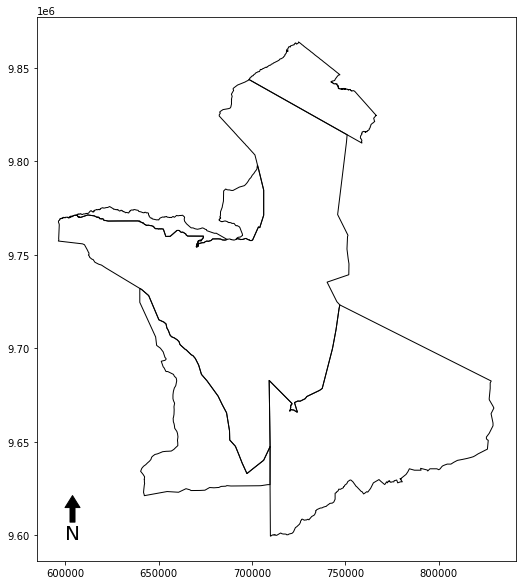

In [12]:
plt.figure(figsize=(10,10))
ax = plt.subplot()

dfpark = gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")

dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


ax.set_aspect('equal')
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

# add code to plot random walk trajectories here
#plt.plot(...
plt.show()

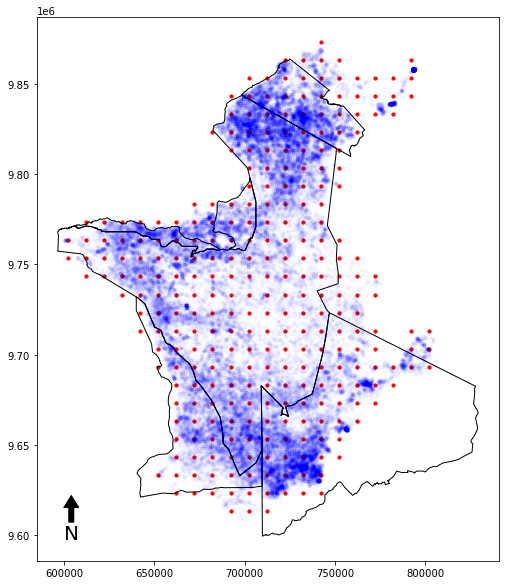

290

In [13]:

# Set up the grid - previous code
offset = 1#50
gridwidth = 10 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell or a neighbouring cell
H = maximum_filter(H, size=1)


xx = xx[H>1]
yy = yy[H>1]


x_grid = np.array([xx.flatten(), yy.flatten()])
x_grid = x_grid.T

num_inducing_points_ = x_grid.shape[0]


np.random.shuffle(x_grid)

#x_grid += np.random.normal(scale=0.1*gridwidth,size=x_grid.shape)
num_inducing_points_

x_grid.shape
plt.figure(figsize=(10,10))
ax = plt.subplot()

dfpark = gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")

dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


ax.set_aspect('equal')
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


plt.plot((x+xmean)*1000,(y+ymean)*1000,'.',c='b',alpha=0.01)
plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=10,c='r')
plt.show()

# # Set up the grid - previous code
# offset = 0
# gridwidth = 10 # width in kilometres
# xmin = gridwidth*(((x.min()-offset)//gridwidth))
# xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

# ymin = gridwidth*(((y.min()-offset)//gridwidth))
# ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

# gridx = np.arange(xmin,xmax,gridwidth)
# gridy = np.arange(ymin,ymax,gridwidth)


# counts = np.zeros((np.unique(ID).shape[0],gridy.shape[0]-1,gridx.shape[0]-1))

# for wid in np.unique(ID):
#     x_w = x[ID==wid]
#     y_w = y[ID==wid]
#     if x_w.shape[0]>SEG_LENGTH:
#         H, yedges, xedges = np.histogram2d(y_w, x_w,bins=[gridy,gridx])
#     H[H>0] = 1
#     counts[wid]=H
#     #print(H.shape)

# counts = np.sum(counts,axis=0)

# H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

# xedges = 0.5*(xedges[1:]+xedges[:-1])
# yedges = 0.5*(yedges[1:]+yedges[:-1])

# xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# # only keep if a wildebeest has been in the cell or a neighbouring cell
# H = maximum_filter(H, size=0)

# xx = xx[counts>2]
# yy = yy[counts>2]
# counts = counts[counts>2]
# plt.figure(figsize=(10,10))
# ax = plt.subplot()

# x_grid = np.array([xx.flatten(), yy.flatten()])
# x_grid = x_grid
# ax.set_aspect('equal')
# xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
# ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=20,
#             xycoords=ax.transAxes)

# x_grid = x_grid.T
# np.random.shuffle(x_grid)
# num_inducing_points_ = x_grid.shape[0]

# plt.plot((x+xmean)*1000,(y+ymean)*1000,'.',c='b',alpha=0.01)

# #plt.plot((x+xmean)*1000,(y+ymean)*1000,'.',c='b',alpha=0.01)
# plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=10,c='k')
# plt.show()

num_inducing_points_

In [14]:
num_inducing_points_

290

In [15]:
# num_inducing_points_ = 50

# X.shape[0]

# r_index =np.random.choice(np.arange(X.shape[0]),num_inducing_points_,replace=False) 
# x_grid = X[r_index]

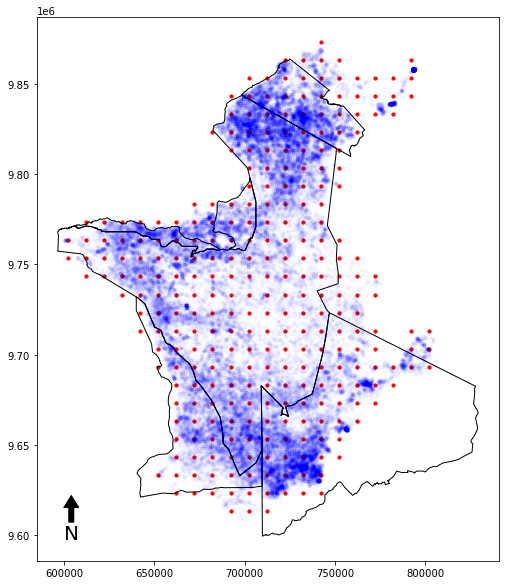

In [16]:
plt.figure(figsize=(10,10))
ax = plt.subplot()

dfpark = gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")

dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


ax.set_aspect('equal')
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


plt.plot((x+xmean)*1000,(y+ymean)*1000,'.',c='b',alpha=0.01)
plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=10,c='r')
plt.show()


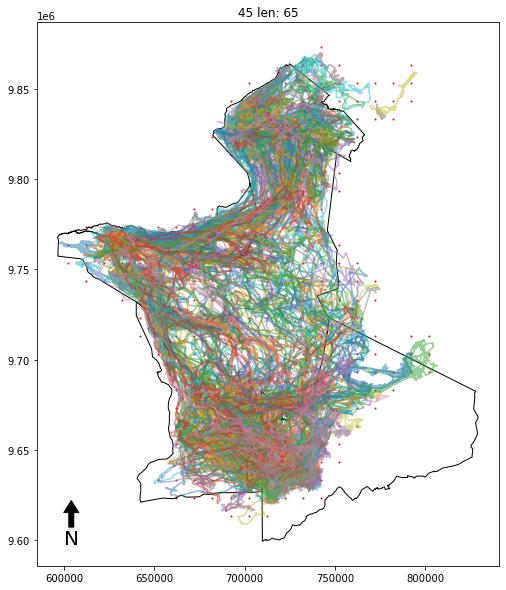

In [17]:

plt.figure(figsize=(10,10))
ax = plt.subplot()

dfpark = gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")

dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


ax.set_aspect('equal')
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
for wid in np.unique(ID):




    #plt.plot((x+xmean)*1000,(y+ymean)*1000,'.',c='b',alpha=0.01)

        #if wid==31:
    plt.plot((x[ID==wid]+xmean)*1000,(y[ID==wid]+ymean)*1000,alpha=0.5)#,c='b')
        #else:
        #    plt.plot((x[ID==wid]+xmean)*1000,(y[ID==wid]+ymean)*1000,'.',alpha=0.01,c='r')

plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=1,c='r')
plt.title(str(wid) + " len: " + str(len(x[ID==wid])))
plt.show()


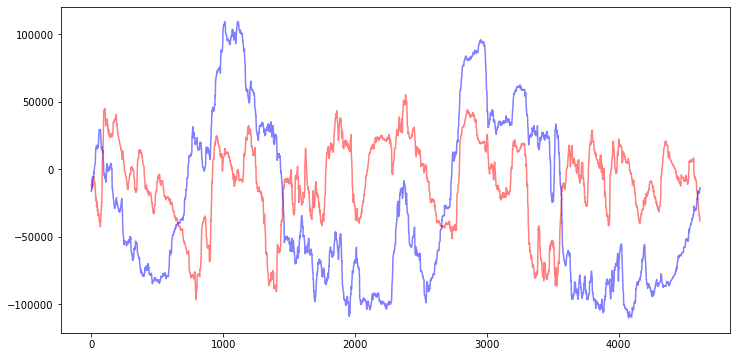

In [18]:
wid=31
plt.plot((x[ID==wid])*1000,alpha=0.5,c='r')
plt.plot((y[ID==wid])*1000,alpha=0.5,c='b')



In [19]:
np.unique(ID)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [20]:
64*4/16

16.0

In [21]:
# create the dataset

BATCH_SIZE=4
SEG_LENGTH=500

allT = []
allX = []
for i in np.unique(ID):
    if T[ID == i].shape[0]<SEG_LENGTH:
        continue
    allT.append(T[ID == i])
    allX.append(X[ID == i])

num_training_points_ = 0
for tt in allT:
    num_training_points_+=(tt.shape[0])
print('..',num_training_points_,'..')

.. 91766 ..


In [22]:
# create the dataset

BATCH_SIZE=4
SEG_LENGTH=500

allT = []
allX = []
for i in np.unique(ID):
    if T[ID == i].shape[0]<SEG_LENGTH:
        continue
    allT.append(T[ID == i])
    allX.append(X[ID == i])

num_training_points_ = 0
for tt in allT:
    num_training_points_+=(tt.shape[0]//SEG_LENGTH)*SEG_LENGTH
print('..',num_training_points_,'..')

.. 84000 ..


In [23]:

class segment_generator:
    def __iter__(self):
        
        # loop over individuals
        self.i = 0
        self.max_i = len(allT)
        
        # loop over segments
        self.j = 0
        #self.max_j = num_training_points_//(self.max_i*SEG_LENGTH)
        
        
        
        return self

    def __next__(self):
        
        if self.i == self.max_i:
            raise StopIteration
                
        T = allT[self.i]
        X = allX[self.i] 

        

        TT = T[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
        XX = X[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
    
        self.j += 1
        
        if (self.j+1)*SEG_LENGTH > T.shape[0]:
            self.i+=1
            self.j=0

        return TT,XX,0.5*(XX[:-1]+XX[1:])

dataset = tf.data.Dataset.from_generator(segment_generator, (tf.float64,tf.float64,tf.float64),output_shapes=(tf.TensorShape([None,1]),tf.TensorShape([None,2]),tf.TensorShape([None,2]))) 
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE)

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
dataset = dataset.with_options(options)


2022-03-15 22:07:22.789940: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-15 22:07:23.899132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15391 MB memory:  -> device: 0, name: Quadro GP100, pci bus id: 0000:3b:00.0, compute capability: 6.0


In [24]:
# (d[2].numpy()[0][:-1]+d[2].numpy()[0][:-1]).shape

In [26]:
for d in dataset:
    print(d[0].shape,d[1].shape,d[2].shape)
    break

(4, 500, 1) (4, 500, 2) (4, 499, 2)


In [74]:
for d in dataset:
    print(d[0].shape,d[1].shape,d[2].shape)
    break

(4, 500, 1) (4, 500, 2) (4, 499, 2)


In [75]:
#tf.math.softplus(vgp.vgp_observation_noise_variance)
#len(dataset)

In [57]:
# in case we need to reload
importlib.reload(nsgp_vi)
from nsgp_vi import nsgpVI

In [58]:
kernel_len_a = tfp.util.TransformedVariable(1,tfb.Softplus(), dtype=tf.float64, name='k_len_a',trainable=1)
kernel_amp_a = tfp.util.TransformedVariable(1,tfb.Softplus(), dtype=tf.float64, name='k_amp_a',trainable=1)
# kernel_mf_a = tfp.util.TransformedVariable(1,tfb.Softplus(), dtype=tf.float64, name='k_mf_a',trainable=1)

# #lengthscale = tfp.util.TransformedVariable(10.,tfb.Exp(), dtype=tf.float64, name='k_env_l')
# kernel_amp_l = tfp.util.TransformedVariable(10.0,tfb.Chain([tfb.Shift(np.float64(5.)),tfb.Softplus()]), dtype=tf.float64, name='k_amp_l',trainable=1)
# kernel_len_l = tfp.util.TransformedVariable(10.0,tfb.Chain([tfb.Shift(np.float64(5.)),tfb.Softplus()]), dtype=tf.float64, name='k_len_l',trainable=1)
# kernel_mf_l = tfp.util.TransformedVariable(10.0,tfb.Chain([tfb.Shift(np.float64(5.)),tfb.Softplus()]), dtype=tf.float64, name='k_mf_l',trainable=1)

#lengthscale = tfp.util.TransformedVariable(10.,tfb.Exp(), dtype=tf.float64, name='k_env_l')
kernel_amp_l = tfp.util.TransformedVariable(15.0,tfb.Chain([tfb.Scale(np.float64(10.0)),tfb.Shift(np.float64(1.)),tfb.Softplus()]), dtype=tf.float64, name='k_amp_l',trainable=1)
kernel_len_l = tfp.util.TransformedVariable(15.0,tfb.Chain([tfb.Scale(np.float64(10.0)),tfb.Shift(np.float64(1.)),tfb.Softplus()]), dtype=tf.float64, name='k_len_l',trainable=1)

#kernel_amp_l = tfp.util.TransformedVariable(20.0,tfb.Chain([tfb.Shift(np.float64(0.)),tfb.Identity()]), dtype=tf.float64, name='k_amp_l',trainable=1)

#kernel_len_l = tfp.util.TransformedVariable(20.0,tfb.Chain([tfb.Shift(np.float64(0.)),tfb.Identity()]), dtype=tf.float64, name='k_len_l',trainable=1)

#kernels on the lower layer
kernel_len = tfk.ExponentiatedQuadratic(kernel_len_a,kernel_len_l)
kernel_amp = tfk.ExponentiatedQuadratic(kernel_amp_a,kernel_amp_l)

# kernel_mf = tfk.ExponentiatedQuadratic(kernel_mf_a,kernel_mf_l)



init_observation_noise_variance = 1e-4 # corresponds to a 10m s.d.
untransformed_obs_noise = np.log(np.exp(init_observation_noise_variance)-1) 


obs_noise_prior = tfp.distributions.Normal(loc=np.float64(untransformed_obs_noise),scale=np.float64(0.1))

# vgp = nsgpVI(kernel_len,kernel_amp,n_inducing_points=num_inducing_points_,
#              inducing_index_points=x_grid,dataset=dataset,num_training_points=num_training_points_, #kernel_mf=kernel_mf,
#              num_sequential_samples=1,num_parallel_samples=32,init_observation_noise_variance=init_observation_noise_variance,
#              jitter=1e-6) 

# vgp = nsgpVI(kernel_len,kernel_amp,n_inducing_points=num_inducing_points_,
#              inducing_index_points=x_grid,dataset=dataset,num_training_points=num_training_points_, 
#              num_covars = num_covar,prior_beta_len_means=prior_beta_len_means,prior_beta_amp_means=prior_beta_amp_means,
#              prior_beta_len_std=prior_beta_len_std,prior_beta_amp_std=prior_beta_amp_std, segment_length = SEG_LENGTH,
#              num_sequential_samples=1,num_parallel_samples=32,init_observation_noise_variance=untransformed_obs_noise,
#              obs_noise_prior=obs_noise_prior,jitter=1e-8) 

vgp = nsgpVI(kernel_len,kernel_amp,n_inducing_points=num_inducing_points_,
             inducing_index_points=x_grid,dataset=dataset,num_training_points=num_training_points_, 
             segment_length = SEG_LENGTH,
             num_sequential_samples=1,num_parallel_samples=32,init_observation_noise_variance=untransformed_obs_noise,
             obs_noise_prior=obs_noise_prior,jitter=1e-8) 


In [ ]:
NUM_EPOCHS=200
loss = vgp.optimize(BATCH_SIZE, NUM_EPOCHS=NUM_EPOCHS)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Loss 1735.656918, klen_l 27.090457, kamp_l 20.879780, obs 0.000554:  26%|██▋       | 53/200 [11:08<29:55, 12.21s/it] 

In [70]:
vgp.kernel_amp.length_scale

<TransformedVariable: dtype=float64, shape=[], fn="chain_of_scale_of_shift_of_softplus", numpy=17.694892255207634>

In [60]:
import matplotlib.ticker as tick
plt.style.use('ggplot') 
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid') 

from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Polygon

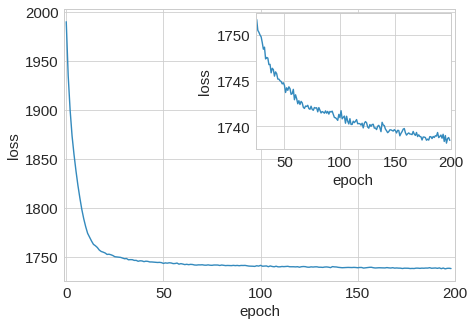

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax0 = plt.subplots(1, 1, figsize=(7,5))#,gridspec_kw={'width_ratios': [1,1,1.5]})
ax0.plot(loss[0][1:],'-',c='C1')



ax0.set_xlabel('epoch',size=15)
ax0.set_ylabel('loss',size=15)
ax0.tick_params(axis='both', which='major', labelsize=15)
ax0.set_xlim(-1,NUM_EPOCHS)

ax1 = inset_axes(ax0, width="50%", height="50%", loc=1)
ax1.plot(np.arange(25,NUM_EPOCHS),loss[0][25:],'-',c='C1')


ax1.set_xlabel('epoch',size=15)
ax1.set_ylabel('loss',size=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlim(24,NUM_EPOCHS)


plt.savefig("serengeti_training_loss.png",dpi=300)

plt.show()

In [62]:

# dense grid for plotting
offset = 0
gridwidth = 2 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)
ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell
H = maximum_filter(H, size=1)

xx = xx[H>0]
yy = yy[H>0]

px_grid = np.array([xx.flatten(), yy.flatten()])
px_grid = px_grid




In [63]:
locations = px_grid.T[None]
S = 1000
len_samples, var_samples = vgp.get_samples(locations,S)#tf.math.exp(vgp.mean_len + scaled_predictors_len + len_samples)
 #= tf.math.exp(vgp.mean_amp + scaled_predictors_amp + amp_samples)

In [64]:
len_samples = len_samples.numpy()[:,0]
std_samples = var_samples.numpy()[:,0]**0.5

In [65]:
mean_len = np.mean(len_samples,axis = 0)[:, np.newaxis]
std_len = np.std(len_samples,axis = 0)[:, np.newaxis]
mean_std = np.mean(std_samples,axis = 0)[:, np.newaxis]
std_std= np.std(std_samples,axis = 0)[:, np.newaxis]


In [66]:
std_q_25 = np.percentile(std_samples,2.5,axis=0)[:, np.newaxis]
std_q_975 = np.percentile(std_samples,97.5,axis=0)[:, np.newaxis]

len_q_25 = np.percentile(len_samples,2.5,axis=0)[:, np.newaxis]
len_q_975 = np.percentile(len_samples,97.5,axis=0)[:, np.newaxis]

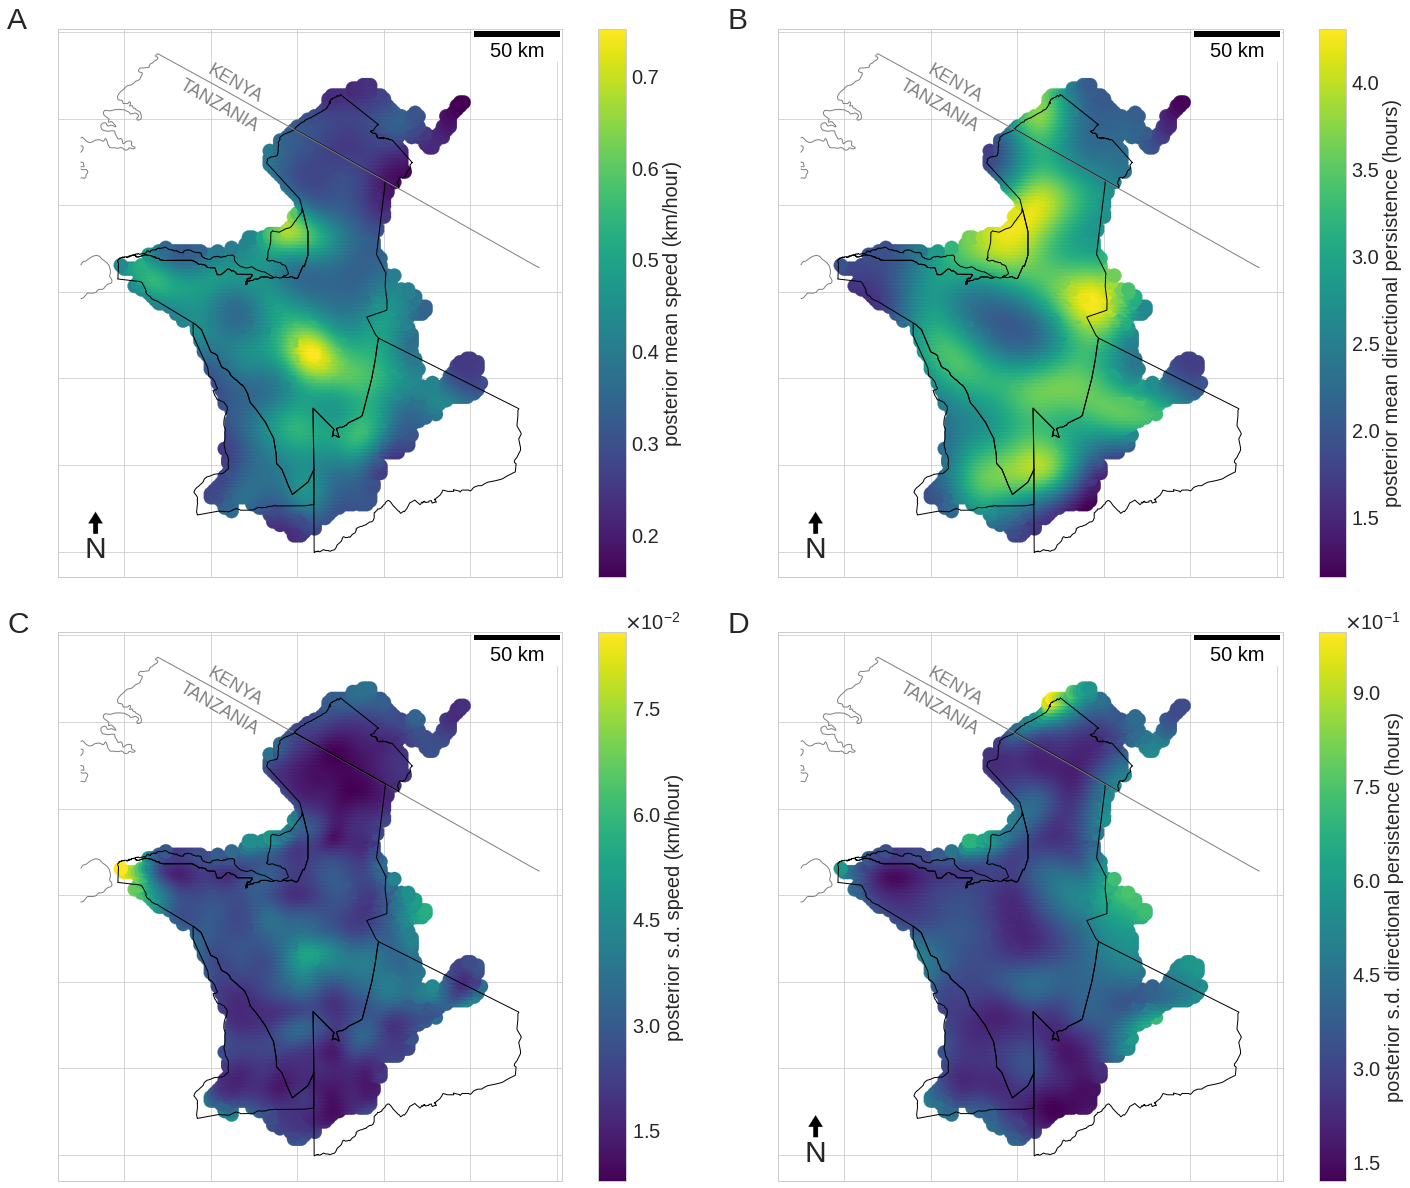

In [73]:
# 2x2 design len and var 

dfborder=gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")
dfTZ=gpd.read_file('../data/wildebeest_data/TZ_border_UTM36S.shp')


dfTZ=  dfTZ.to_crs(dfborder.crs)
polygon = Polygon([[5.75e5,9.6e6], [8.4e5,9.6e6], [8.4e5,9.95e6], [5.75e5,9.95e6], [5.75e5,9.6e6]])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=dfborder.crs)
dfTZ = gpd.clip(dfTZ, poly_gdf)
dfTZ = dfTZ.translate(0, 1000)
fig, axs = plt.subplots(2, 2, figsize=(40,20))

#mean_var
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[0,0],color='black',linewidth=1)
dfTZ.plot(ax=axs[0,0],color='gray',linewidth=1)
axs[0, 0].set_aspect('equal')
axs[0, 0].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[0, 0].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[0,0].transAxes)
axs[0, 0].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[0,0].transAxes)
axs[0, 0].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[0,0].transAxes)
ax00 = axs[0, 0].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=mean_std,cmap='viridis',marker='o',s=200)#vmin,vmax
#axs[0,0].set_title('A',loc='left',size=30,pad=100)
axs[0,0].text(-0.1,1,'A', size=30, transform=axs[0, 0].transAxes)
axs[0,0].tick_params( labelleft=False, labelbottom=False) 
cbar = fig.colorbar(ax00, ax=axs[0, 0],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=20) 
cbar.set_label(label='posterior mean speed (km/hour)',size=20)
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

#std_var
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[0,1],color='black',linewidth=1)
dfTZ.plot(ax=axs[1,0],color='gray',linewidth=1)
axs[1, 0].set_aspect('equal')
axs[1, 0].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[1, 0].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[0,1].transAxes)
axs[1, 0].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[1,0].transAxes)
axs[1, 0].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[1,0].transAxes)
ax10 = axs[1, 0].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=std_std,cmap='viridis',marker='o',s=200)#vmin,vmax
#axs[1,0].set_title('C',loc='center',size=30)
axs[1,0].text(-0.1,1,'C', size=30, transform=axs[1, 0].transAxes)

axs[1,0].tick_params( labelleft=False, labelbottom=False) 
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
cbar = fig.colorbar(ax10, ax=axs[1, 0],format=formatter)
# cbar = fig.colorbar(ax01, ax=axs[1, 0],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=20) 
cbar.ax.yaxis.offsetText.set_fontsize(20)
cbar.ax.yaxis.offsetText.set_x(3)
cbar.set_label(label='posterior s.d. speed (km/hour)',size=20)
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

#mean_len
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[1,0],color='black',linewidth=1)
dfTZ.plot(ax=axs[0,1],color='gray',linewidth=1)
axs[0, 1].set_aspect('equal')
axs[0, 1].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[0, 1].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[1,0].transAxes)
axs[0,1].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[0,1].transAxes)
axs[0,1].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[0,1].transAxes)
ax01= axs[0, 1].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=mean_len,cmap='viridis',marker='o',s=200)#vmin,vmax

axs[0,1].text(-0.1,1,'B', size=30, transform=axs[0, 1].transAxes)

axs[0,1].tick_params( labelleft=False, labelbottom=False) 
cbar = fig.colorbar(ax01, ax=axs[0, 1],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=20) 
cbar.set_label(label='posterior mean directional persistence (hours)',size=20)
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

#std_len
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[1,1],color='black',linewidth=1)
dfTZ.plot(ax=axs[1,1],color='gray',linewidth=1)
axs[1, 1].set_aspect('equal')
axs[1, 1].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[1, 1].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[1,1].transAxes)
axs[1, 1].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[1,1].transAxes)
axs[1, 1].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[1,1].transAxes)
ax11 = axs[1, 1].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=std_len,cmap='viridis',marker='o',s=200)#,vmax=0.02,vmin=0)#vmin,vmax

axs[1,1].text(-0.1,1,'D', size=30, transform=axs[1, 1].transAxes)

axs[1,1].tick_params( labelleft=False, labelbottom=False) 
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
cbar = fig.colorbar(ax11, ax=axs[1, 1],format=formatter)
cbar.set_label(label='posterior s.d. directional persistence (hours)',size=20)

cbar.ax.tick_params(labelsize=20) 
cbar.ax.yaxis.offsetText.set_fontsize(20)
cbar.ax.yaxis.offsetText.set_x(3)

tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()



plt.tick_params( labelleft=False, labelbottom=False) 
plt.subplots_adjust(left=0.2,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.0001, 
                    hspace=0.1)


plt.savefig("serengeti_spatial.png",bbox_inches='tight',dpi=300)
plt.show()


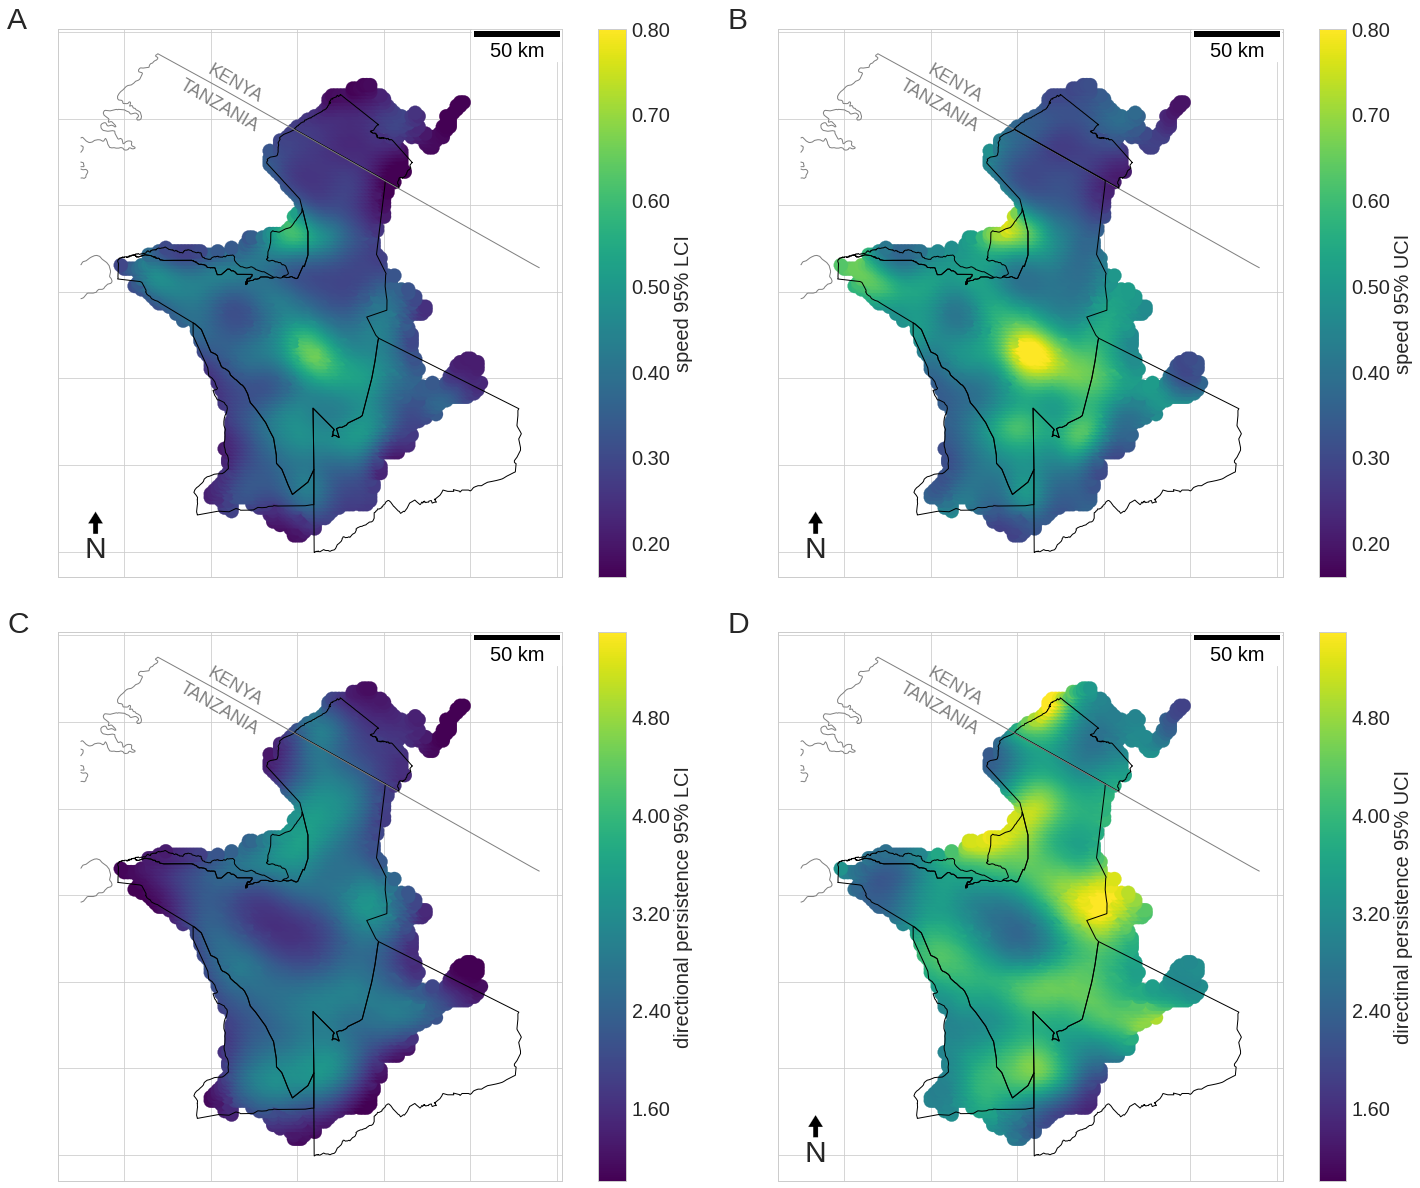

In [79]:


# 2x2 design len and var 


fig, axs = plt.subplots(2, 2, figsize=(40,20))

#std q25
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[0,0],color='black',linewidth=1)
dfTZ.plot(ax=axs[0,0],color='gray',linewidth=1)
axs[0, 0].set_aspect('equal')
axs[0, 0].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[0, 0].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[0,0].transAxes)
axs[0, 0].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[0,0].transAxes)
axs[0, 0].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[0,0].transAxes)
ax00 = axs[0, 0].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=std_q_25,cmap='viridis',marker='o',s=200,vmin=0.16,vmax=0.8)#,vmax=25)#vmin,vmax
#axs[0,0].set_title('A',loc='center',size=30)
axs[0,0].text(-0.1,1,'A', size=30, transform=axs[0, 0].transAxes)

axs[0,0].tick_params( labelleft=False, labelbottom=False) 
cbar = fig.colorbar(ax00, ax=axs[0, 0],format=tick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=20) 
cbar.set_label(label='speed 95% LCI',size=20)

tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

#std q975
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[1,0],color='black',linewidth=1)
dfTZ.plot(ax=axs[0,1],color='gray',linewidth=1)
axs[0, 1].set_aspect('equal')
axs[0, 1].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[0, 1].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[1,0].transAxes)
axs[0,1].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[0,1].transAxes)
axs[0,1].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[0,1].transAxes)
ax10= axs[0, 1].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=std_q_975,cmap='viridis',marker='o',s=200,vmin=0.16,vmax=0.8)#,vmax=25)#vmin,vmax
#axs[0,1].set_title('B',loc='center',size=30)
axs[0,1].text(-0.1,1,'B', size=30, transform=axs[0, 1].transAxes)

axs[0,1].tick_params( labelleft=False, labelbottom=False) 
cbar = fig.colorbar(ax10, ax=axs[0, 1],format=tick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=20) 
cbar.set_label(label='speed 95% UCI',size=20)
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()
#len q25

dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[0,1],color='black',linewidth=1)
dfTZ.plot(ax=axs[1,0],color='gray',linewidth=1)
axs[1, 0].set_aspect('equal')
axs[1, 0].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[1, 0].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[0,1].transAxes)
axs[1, 0].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[1,0].transAxes)
axs[1, 0].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[1,0].transAxes)
ax01 = axs[1, 0].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=len_q_25,cmap='viridis',marker='o',s=200,vmin=1.0,vmax=5.5)#vmin,vmax
#axs[1,0].set_title('C',loc='center',size=30)
axs[1,0].text(-0.1,1,'C', size=30, transform=axs[1,0].transAxes)

axs[1,0].tick_params( labelleft=False, labelbottom=False) 
cbar = fig.colorbar(ax01, ax=axs[1, 0],format=tick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=20) 
cbar.set_label(label='directional persistence 95% LCI',size=20)
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()


#len q97.5
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[1,1],color='black',linewidth=1)
dfTZ.plot(ax=axs[1,1],color='gray',linewidth=1)
axs[1, 1].set_aspect('equal')
axs[1, 1].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[1, 1].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[1,1].transAxes)
axs[1, 1].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[1,1].transAxes)
axs[1, 1].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[1,1].transAxes)
ax11 = axs[1, 1].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=len_q_975,cmap='viridis',marker='o',s=200,vmin=1.0,vmax=5.5)#vmin,vmax
#axs[1,1].set_title('D',loc='center',size=30)
axs[1,1].text(-0.1,1,'D', size=30, transform=axs[1, 1].transAxes)

axs[1,1].tick_params( labelleft=False, labelbottom=False) 
cbar = fig.colorbar(ax11, ax=axs[1, 1],format=tick.FormatStrFormatter('%.2f'))
cbar.set_label(label='directinal persistence 95% UCI',size=20)
cbar.ax.tick_params(labelsize=20) 
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()



plt.tick_params( labelleft=False, labelbottom=False) 
plt.subplots_adjust(left=0.2,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.0001, 
                    hspace=0.1)




plt.savefig("serengeti_quantiles.png",bbox_inches='tight',dpi=300)

plt.show()


In [85]:

# time_points = d[0]
# locations = d[1]
# predictor_values = d[2]

# len_vals, amp_vals = vgp.get_samples(locations,predictor_values,S=vgp.num_parallel_samples)   
# len_vals.shape
# K = vgp.non_stat_vel(time_points, len_vals, amp_vals) # BxNxN
# K = K + (tf.eye(tf.shape(K)[-1], dtype=tf.float64) * ((vgp.obs_max * tf.nn.sigmoid(vgp.vgp_observation_noise_variance))+vgp.jitter))

# x_mean_vels, y_mean_vels = vgp.get_mean_samples(locations,S=vgp.num_parallel_samples)   

# centered_locations = locations[...,:,:]-locations[...,0,None,:] #centered observations

# timedifference = tf.expand_dims((time_points[:,1:])-(time_points[:,:-1]),0)

# delta_x = x_mean_vels*timedifference
# delta_y = y_mean_vels*timedifference

# mean_x = tf.expand_dims(centered_locations,0)[...,:-1,0,None]+delta_x
# mean_y = tf.expand_dims(centered_locations,0)[...,:-1,1,None]+delta_y

# logpdf_K_x = tf.reduce_sum(tf.reduce_mean(tfd.MultivariateNormalTriL(loc=mean_x[...,0],scale_tril = tf.linalg.cholesky(K)).log_prob((centered_locations[...,1:,0])),axis=0))
# logpdf_K_y = tf.reduce_sum(tf.reduce_mean(tfd.MultivariateNormalTriL(loc=mean_y[...,0],scale_tril = tf.linalg.cholesky(K)).log_prob((centered_locations[...,1:,1])),axis=0))

# mean_y.shape

In [86]:
#delta_x

In [87]:
# #plt.plot(centered_locations[0,:,0].numpy())
# for i in range(64):
#     plt.plot(mean_x[i,0,:,0].numpy()-centered_locations[0,1:,0].numpy(),c='C0',alpha=0.1)

In [ ]:
loss = vgp.optimize(BATCH_SIZE, SEG_LENGTH, NUM_EPOCHS=200,lr=0.05)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Loss 1741.773474, klen_l 23.180722, kamp_l 20.649449, obs 0.004241:  18%|█▊        | 35/200 [26:32<2:09:16, 47.01s/it]

In [ ]:
plt.plot(loss[0][1:])
plt.show()

plt.plot(loss[1][1:])
plt.show()
# for d in dataset:

#     x_train_batch = d[1]
#     t_train_batch = d[0]
#     predictor_batch = d[1]
    
#     kl_weight = tf.reduce_sum(tf.ones_like(t_train_batch))/vgp.num_training_points
    
# # 01             t_train_batch, x_train_batch, predictor_batch = inputs
    
# # 103 
#     with tf.GradientTape(watch_accessed_variables=True) as tape:
        
#         kl_penalty = vgp.penalty()
#         recon = vgp.surrogate_posterior_expected_log_likelihood(locations,time_points,predictor_values)
# # 147         return -recon  + 2.0*kl_weight*kl_penalty
#         loss = recon#vgp.variational_loss(locations=x_train_batch,time_points=t_train_batch,predictor_values=predictor_batch, kl_weight=kl_weight)
#     grads = tape.gradient(loss, vgp.trainable_variables)
#     break

In [622]:
# grads

In [623]:

# gg3 = []
# for g in tqdm(range(100)):
#     kl_weight = tf.reduce_sum(tf.ones_like(t_train_batch))/vgp.num_training_points

#     # 01             t_train_batch, x_train_batch, predictor_batch = inputs

#     # 103 
#     with tf.GradientTape(watch_accessed_variables=True) as tape:

#         kl_penalty = vgp.penalty()
#         #recon = vgp.surrogate_posterior_expected_log_likelihood(x_train_batch[0,None],t_train_batch[0,None],predictor_batch[0,None])
        
#         locations = x_train_batch[0,None]
#         len_vals, amp_vals = vgp.get_samples(predictor_batch[0,None],S=200)
#         K = vgp.non_stat_vel(t_train_batch[0,None], len_vals, amp_vals) # BxNxN
#         K = K + (tf.eye(tf.shape(K)[-1], dtype=tf.float64) * ((tf.nn.softplus(vgp.vgp_observation_noise_variance))+vgp.jitter))


#         centered_locations = locations[...,1:,:]-locations[...,0,None,:] #centered observations

#         logpdf_K_x = tf.reduce_sum(tf.reduce_mean(tfd.MultivariateNormalTriL(scale_tril = tf.linalg.cholesky(K)).log_prob((centered_locations[...,0])),axis=0))
#         logpdf_K_y = tf.reduce_sum(tf.reduce_mean(tfd.MultivariateNormalTriL(scale_tril = tf.linalg.cholesky(K)).log_prob((centered_locations[...,1])),axis=0))

#         recon =  logpdf_K_x + logpdf_K_y
#     # 147         return -recon  + 2.0*kl_weight*kl_penalty
#         loss = recon#vgp.variational_loss(locations=x_train_batch,time_points=t_train_batch,predictor_values=predictor_batch, kl_weight=kl_weight)
#     grads = tape.gradient(loss, vgp.trainable_variables)
#     gg3.append(grads[0].numpy())

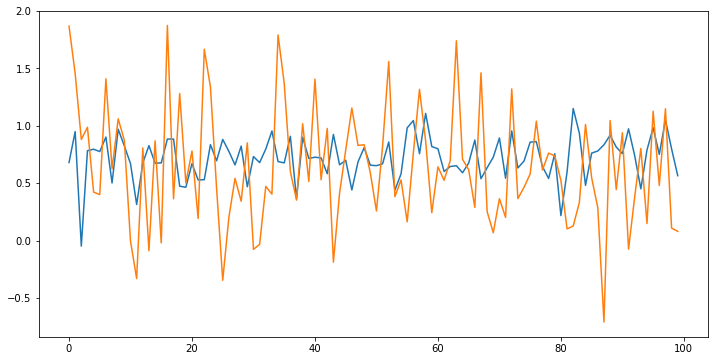

In [624]:
plt.plot(gg)
plt.plot(gg2)
plt.plot(gg3)

plt.show()


In [70]:
#vgp.vgp_observation_noise_variance

-9.210290371559083

In [35]:
1000*vgp.obs_max*tf.nn.sigmoid(vgp.vgp_observation_noise_variance)**0.5

# 1000*tf.nn.softplus(-9.15)**0.5

# tf.nn.softplus(-9.15)#1e-4

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([9.99999988])>

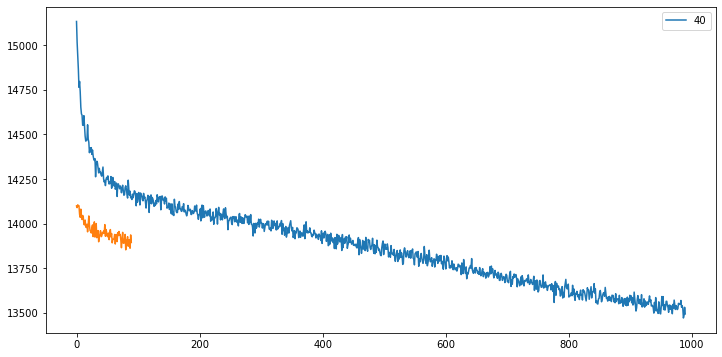

In [445]:
plt.plot(loss[10:],label='40')
plt.plot(loss2[10:])
plt.legend()
plt.show()

In [456]:
vgp.penalty()

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([486.40302056])>

In [30]:
#vgp.q_mu.numpy()
vgp.kernel_amp.length_scale

<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=17.693064358692098>

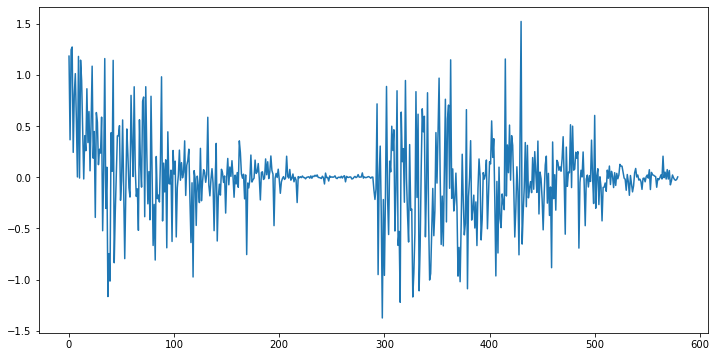

In [48]:
plt.plot(vgp.q_mu.numpy())

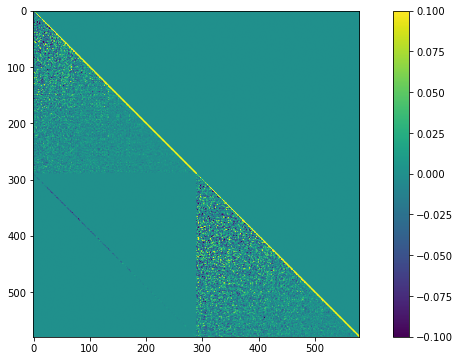

In [56]:
plt.imshow(vgp.q_sqrt.to_dense().numpy()[0],vmax=0.1,vmin=-0.1)
plt.colorbar()

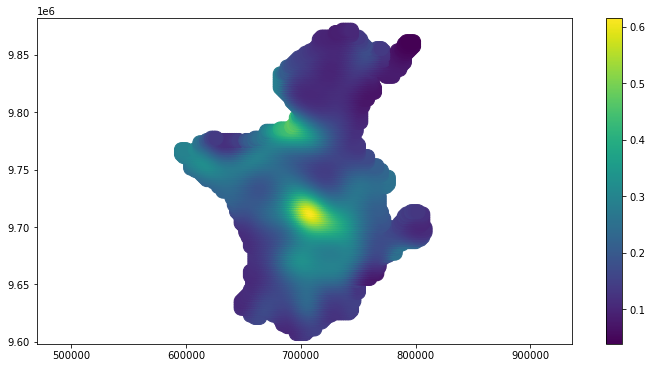

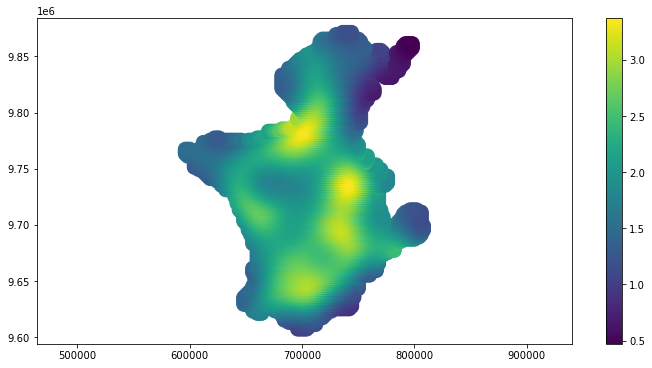

In [82]:

# dense grid for plotting
offset = 10
gridwidth = 2 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)
ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell
H = maximum_filter(H, size=3)

xx = xx[H>0]
yy = yy[H>0]

px_grid = np.array([xx.flatten(), yy.flatten()])
pX_grid=px_grid.T


pmean_list, var_list = vgp.get_marginal(px_grid.T[None])

#mean, var = vgp.get_conditional(px_grid.T)

#pmean_list = tf.split(mean[0],2,axis=0)
        
len_grid = (tf.math.softplus(vgp.mean_len) + tf.math.sigmoid(pmean_list[0])).numpy()#0.0+tf.math.exp(vgp.mean_len+mean_list[0]).numpy() #+ 0.0*var_list[0].numpy()
var_grid = (tf.math.softplus(vgp.mean_amp) + tf.math.sigmoid(pmean_list[1])).numpy()#0.0+tf.math.exp(vgp.mean_len+mean_list[0]).numpy() #+ 0.0*var_list[0].numpy()


len_grid = 0.0+tf.math.exp(vgp.mean_len+pmean_list[0]).numpy() #+ 0.0*var_list[0].numpy()
var_grid = 0.0+tf.math.exp(vgp.mean_amp+pmean_list[1]).numpy() #+ 0.0*var_list[0].numpy()

#var_grid = tf.math.exp(vgp.mean_amp+mean_list[1]).numpy()**0.5
plt.scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=(var_grid),cmap='viridis',marker='o',s=200)#,vmax=20)#vmin,vmax
plt.colorbar()

#plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=10,c='r')

plt.axis('equal')

plt.xlim([1000*(xmin+xmean), 1000*(xmax+xmean)])
plt.ylim([1000*(ymin+ymean),1000*(ymax+ymean)])

plt.show()
#plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=10,c='r')
#plt.figure(figsize=(20,20))
plt.scatter((px_grid[0]+xmean)*1000+0000,(px_grid[1]+ymean)*1000,c=(len_grid),cmap='viridis',marker='o',s=200)#,vmax=10.,vmin=0.05)#vmin,vmax
plt.colorbar()
plt.axis('equal')



# plt.figure(figsize=(10,10))
# ax = plt.subplot()

# dfpark = gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")

# dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


# ax.set_aspect('equal')
# xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
# ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=20,
#             xycoords=ax.transAxes)
#for wid in np.unique(ID):




    #plt.plot((x+xmean)*1000,(y+ymean)*1000,'.',c='b',alpha=0.01)

        #if wid==31:
#    plt.plot((x[ID==wid]+xmean)*1000,(y[ID==wid]+ymean)*1000,'.',alpha=0.1)#,c='b')
        #else:
        #    plt.plot((x[ID==wid]+xmean)*1000,(y[ID==wid]+ymean)*1000,'.',alpha=0.01,c='r')

#plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=1,c='r')
#plt.title(str(wid) + " len: " + str(len(x[ID==wid])))
#plt.show()

#plt.xlim([1000*(xmin+xmean), 1000*(xmax+xmean)])
#plt.ylim([1000*(ymin+xmean),1000*(ymax+xmean)])

plt.show()



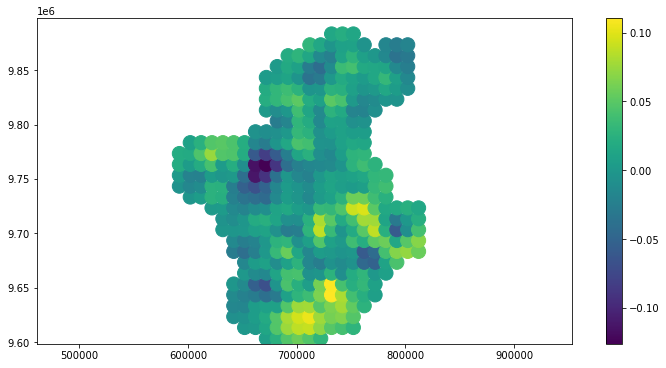

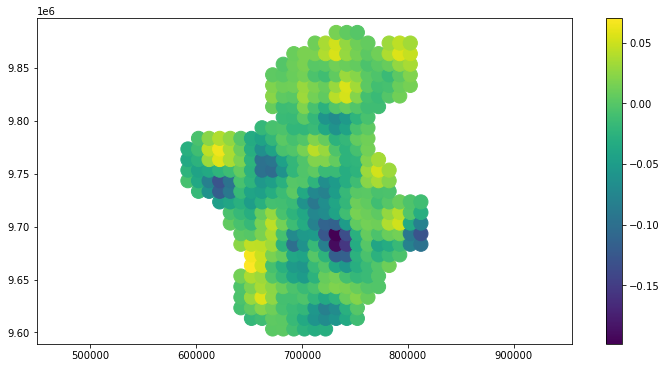

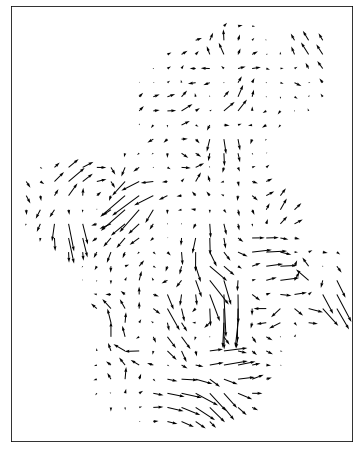

In [59]:

# dense grid for plotting
offset = 10
gridwidth = 10 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)
ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell
H = maximum_filter(H, size=3)

xx = xx[H>0]
yy = yy[H>0]

px_grid = np.array([xx.flatten(), yy.flatten()])
pX_grid=px_grid.T


vmean_x, vmean_y, vcov_x, vcov_y = vgp.get_marginal_mean(px_grid.T[None])

#mean, var = vgp.get_conditional(px_grid.T)

#pmean_list = tf.split(mean[0],2,axis=0)

#var_grid = tf.math.exp(vgp.mean_amp+mean_list[1]).numpy()**0.5
plt.scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=(vmean_x),cmap='viridis',marker='o',s=200)#,vmax=20)#vmin,vmax
plt.colorbar()

#plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=10,c='r')

plt.axis('equal')

plt.xlim([1000*(xmin+xmean), 1000*(xmax+xmean)])
plt.ylim([1000*(ymin+ymean),1000*(ymax+ymean)])

plt.show()
#plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=10,c='r')
#plt.figure(figsize=(20,20))
plt.scatter((px_grid[0]+xmean)*1000+0000,(px_grid[1]+ymean)*1000,c=(vmean_y),cmap='viridis',marker='o',s=200)#,vmax=10.,vmin=0.05)#vmin,vmax
plt.colorbar()
plt.axis('equal')

# creating plot
fig, ax = plt.subplots(figsize =(14, 8))
ax.quiver((px_grid[0]+xmean)*1000, (px_grid[1]+ymean)*1000, vmean_x.numpy()[0,:,0], vmean_y.numpy()[0,:,0])#,scale=2)
 
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

ax.set_aspect('equal')
 
# show plot
plt.show()

# plt.figure(figsize=(10,10))
# ax = plt.subplot()

# dfpark = gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")

# dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


# ax.set_aspect('equal')
# xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
# ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=20,
#             xycoords=ax.transAxes)
#for wid in np.unique(ID):




    #plt.plot((x+xmean)*1000,(y+ymean)*1000,'.',c='b',alpha=0.01)

        #if wid==31:
#    plt.plot((x[ID==wid]+xmean)*1000,(y[ID==wid]+ymean)*1000,'.',alpha=0.1)#,c='b')
        #else:
        #    plt.plot((x[ID==wid]+xmean)*1000,(y[ID==wid]+ymean)*1000,'.',alpha=0.01,c='r')

#plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=1,c='r')
#plt.title(str(wid) + " len: " + str(len(x[ID==wid])))
#plt.show()

#plt.xlim([1000*(xmin+xmean), 1000*(xmax+xmean)])
#plt.ylim([1000*(ymin+xmean),1000*(ymax+xmean)])

plt.show()



In [48]:
vmean_x.shape

TensorShape([1, 6702, 1])

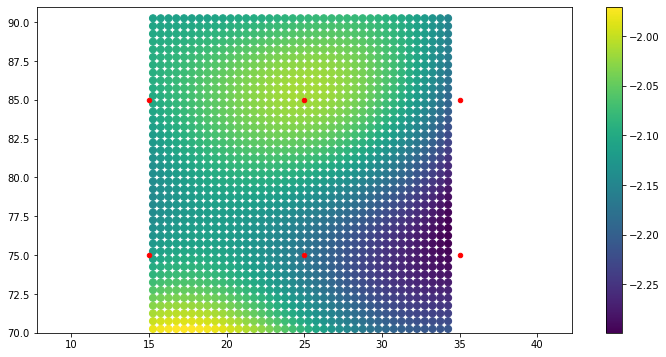

In [538]:

# dense grid for plotting
offset = 10
gridwidth = 0.5 # width in kilometres
xmin = 15#0.4*gridwidth*(((x.min()-offset)//gridwidth))
xmax = 35#0.6*gridwidth*(((x.max()+offset)//gridwidth)+2)
ymin = 70#0.1*gridwidth*(((y.min()-offset)//gridwidth))
ymax = 91#0.9*gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell
H = maximum_filter(H, size=1)

#xx = xx[H>0]
#yy = yy[H>0]

px_grid = np.array([xx.flatten(), yy.flatten()])
pX_grid=px_grid.T


pmean_list, var_list = vgp.get_marginal(px_grid.T[None])

#mean, var = vgp.get_conditional(px_grid.T)

#pmean_list = tf.split(mean[0],2,axis=0)
        
len_grid = (tf.math.softplus(vgp.mean_len) + tf.math.sigmoid(pmean_list[0])).numpy()#0.0+tf.math.exp(vgp.mean_len+mean_list[0]).numpy() #+ 0.0*var_list[0].numpy()
var_grid = (tf.math.softplus(vgp.mean_amp) + tf.math.sigmoid(pmean_list[1])).numpy()#0.0+tf.math.exp(vgp.mean_len+mean_list[0]).numpy() #+ 0.0*var_list[0].numpy()


len_grid = 0.0+tf.math.exp(vgp.mean_len+pmean_list[0]).numpy() #+ 0.0*var_list[0].numpy()
var_grid = (vgp.mean_amp+pmean_list[1]).numpy()
#var_grid = 0.0+tf.math.exp(vgp.mean_amp+pmean_list[1]).numpy() #+ 0.0*var_list[0].numpy()
plt.figure()
#var_grid = tf.math.exp(vgp.mean_amp+mean_list[1]).numpy()**0.5
plt.scatter((px_grid[0]),(px_grid[1]),c=(var_grid),cmap='viridis',marker='o',s=50)#,vmax=20)#vmin,vmax
plt.colorbar()

plt.scatter((x_grid[:,0]),(x_grid[:,1]),s=20,c='r')

plt.axis('equal')

plt.xlim([(xmin), (xmax)])
plt.ylim([(ymin),(ymax)])

plt.show()
# plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=10,c='r')

# plt.scatter((px_grid[0]+xmean)*1000+0000,(px_grid[1]+ymean)*1000,c=(len_grid),cmap='viridis',marker='o',s=200)#,vmax=3.19,vmin=2.05)#vmin,vmax
# plt.colorbar()
# plt.axis('equal')

# #plt.xlim([1000*(xmin+xmean), 1000*(xmax+xmean)])
# #plt.ylim([1000*(ymin+xmean),1000*(ymax+xmean)])

# plt.show()



(array([ 24.,  32.,  50.,  90.,  94., 112., 154., 247., 436., 360.]),
 array([-0.35659475, -0.32248093, -0.28836711, -0.25425328, -0.22013946,
        -0.18602564, -0.15191181, -0.11779799, -0.08368417, -0.04957034,
        -0.01545652]),
 <BarContainer object of 10 artists>)

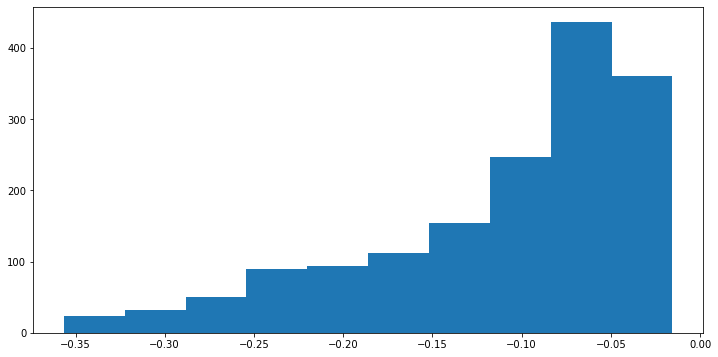

In [506]:
plt.hist(pmean_list[1].numpy()[0])

In [508]:
var_grid[0]

array([[-0.07388098],
       [-0.07076923],
       [-0.06494679],
       ...,
       [-0.06617457],
       [-0.07520442],
       [-0.08193968]])

In [195]:
am, cv = vgp.get_conditional_old(X)
am, cvnew = vgp.get_conditional(X)

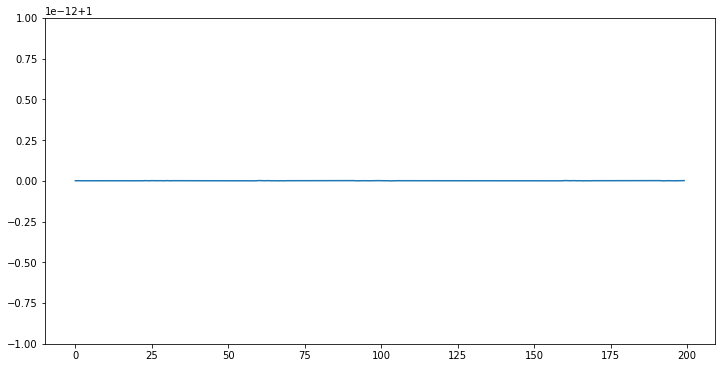

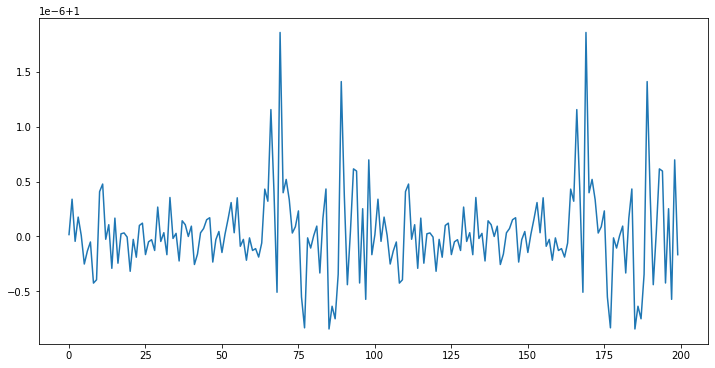

In [196]:
plt.plot(tf.linalg.diag_part(cvnew).numpy()[0])
plt.show()
plt.plot(tf.linalg.diag_part(cv).numpy()[0])
plt.show()

In [169]:
#vgp.inducing_index_points
covar_f.shape

TensorShape([1, 200, 200])

In [166]:
Z = vgp.inducing_index_points 
M = num_inducing_points_#self.M
X = predictor_values[0,None]

tf.debugging.assert_rank(X,3,message="get_marginal expects a batch of locations. Add first dimension of size 1 if processing a single batch" )


In [167]:

Lm_len = tf.linalg.LinearOperatorFullMatrix(vgp.kernel_len.matrix(Z,Z) + vgp.jitter * tf.eye(M, dtype=tf.float64),is_positive_definite=True,is_self_adjoint=True).cholesky()
Lm_amp = tf.linalg.LinearOperatorFullMatrix(vgp.kernel_amp.matrix(Z,Z) + vgp.jitter * tf.eye(M, dtype=tf.float64),is_positive_definite=True,is_self_adjoint=True).cholesky()

Kmn_len = tf.linalg.LinearOperatorFullMatrix(vgp.kernel_len.matrix(Z, X),is_positive_definite=True,is_self_adjoint=True)
Kmn_amp = tf.linalg.LinearOperatorFullMatrix(vgp.kernel_amp.matrix(Z, X),is_positive_definite=True,is_self_adjoint=True)

Lm_len_inv_Kmn = Lm_len.solve(Kmn_len)
Lm_amp_inv_Kmn = Lm_amp.solve(Kmn_amp)
Lm_inv_Kmn = tf.linalg.LinearOperatorBlockDiag([Lm_len_inv_Kmn,Lm_amp_inv_Kmn])

mean_f = tf.expand_dims(Lm_inv_Kmn.matvec(vgp.q_mu, adjoint=True),-1)

Lm_inv_Kmn_q = Lm_inv_Kmn.matmul(vgp.q_sqrt, adjoint=True)
Lm_inv_Kmn_q2 = Lm_inv_Kmn_q.matmul(Lm_inv_Kmn_q,adjoint_arg=True)


Knn_len = tf.linalg.LinearOperatorFullMatrix(vgp.kernel_len.matrix(X, X),is_positive_definite=True,is_self_adjoint=True)
Knn_amp = tf.linalg.LinearOperatorFullMatrix(vgp.kernel_amp.matrix(X, X),is_positive_definite=True,is_self_adjoint=True)

Knn = tf.linalg.LinearOperatorBlockDiag([Knn_len,Knn_amp])

Lm_len_inv_Kmn2 = Lm_len_inv_Kmn.matmul(Lm_len_inv_Kmn,adjoint=True)
Lm_amp_inv_Kmn2 = Lm_amp_inv_Kmn.matmul(Lm_amp_inv_Kmn,adjoint=True)
Lm_inv_Kmn2 = tf.linalg.LinearOperatorBlockDiag([Lm_len_inv_Kmn2,Lm_amp_inv_Kmn2])

covar_f = Lm_inv_Kmn_q2.to_dense() + Knn.to_dense() - Lm_inv_Kmn2.to_dense()

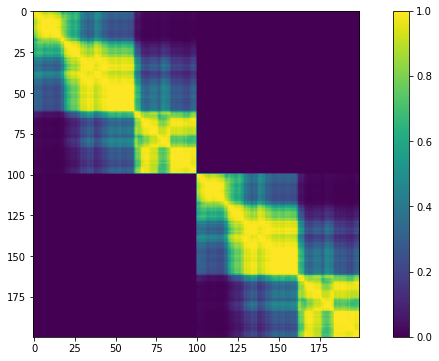

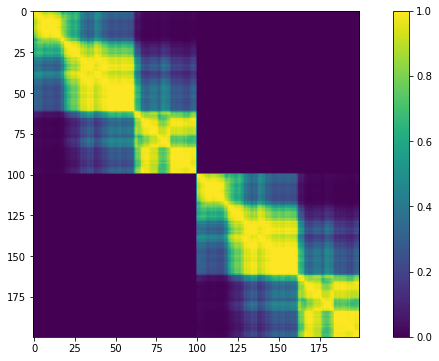

In [198]:
plt.imshow(cvnew.numpy()[0])
plt.colorbar()
plt.show()
plt.imshow(cv.numpy()[0])
plt.colorbar()
plt.show()

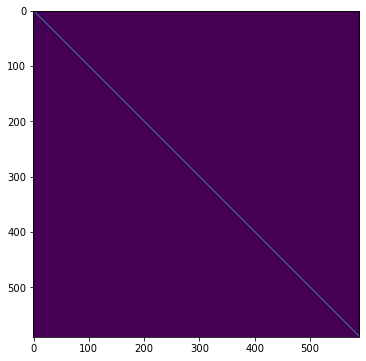

In [130]:
plt.imshow(vgp.q_sqrt.to_dense().numpy()[0])

In [120]:
Lm_inv_Kmn2.to_dense().shape

TensorShape([16, 200, 200])

In [138]:
vgp.kernel_len.amplitude

<TransformedVariable: dtype=float64, shape=[], fn="softplus", numpy=0.6616107165188587>

In [ ]:
        
        kernel_amp = self.kernel_amp
        kernel_len = self.kernel_len

        M = tf.shape(self.q_mu)[0]

        
        Kmm = tf.linalg.LinearOperatorBlockDiag([Kmm_len,Kmm_amp])


        Kmn_amp = tf.linalg.LinearOperatorFullMatrix(kernel_amp.matrix(Z, Xnew),is_positive_definite=True,is_self_adjoint=True)
        Kmn_len = tf.linalg.LinearOperatorFullMatrix(kernel_len.matrix(Z, Xnew),is_positive_definite=True,is_self_adjoint=True)
        Kmn = tf.linalg.LinearOperatorBlockDiag([Kmn_len,Kmn_amp])


        Knn_amp = tf.linalg.LinearOperatorFullMatrix(kernel_amp.matrix(Xnew, Xnew),is_positive_definite=True,is_self_adjoint=True)
        Knn_len = tf.linalg.LinearOperatorFullMatrix(kernel_len.matrix(Xnew, Xnew),is_positive_definite=True,is_self_adjoint=True)
        Knn = tf.linalg.LinearOperatorBlockDiag([Knn_len,Knn_amp])

        mean,var = self.full_conditional(Kmn,Kmm,Knn,self.q_mu,self.q_sqrt)

In [259]:
vgp.kernel_len.trainable_variables

(<tf.Variable 'k_len_a:0' shape=() dtype=float64, numpy=1.3800691428904934>,
 <tf.Variable 'k_len_l:0' shape=() dtype=float64, numpy=15.400482882239002>)

In [89]:
# aa = tfp.distributions.Gamma(concentration=np.float64(250),rate=np.float64(1))
# xx = np.arange(0,100)
# aa = tfp.distributions.LogNormal(loc=np.float64(5),scale=np.float64(1))
# aa = tfd.SinhArcsinh(loc=30.0, scale=10.0,skewness=2.0)


# plt.plot(xx,aa.log_prob(xx))
# plt.show()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Loss 5579.826507, klen_l 31.054516, kamp_l 0.001117:   6%|▌         | 58/1000 [05:19<1:23:54,  5.34s/it]

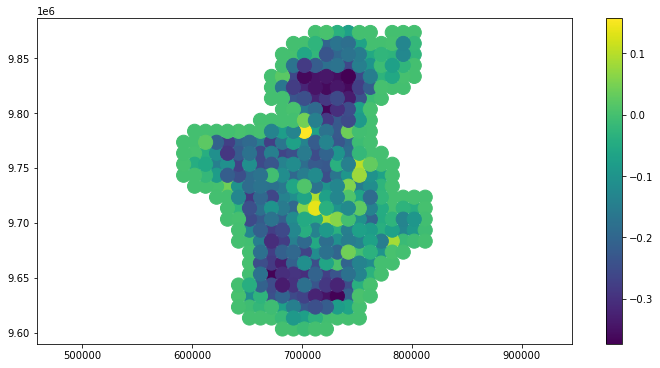

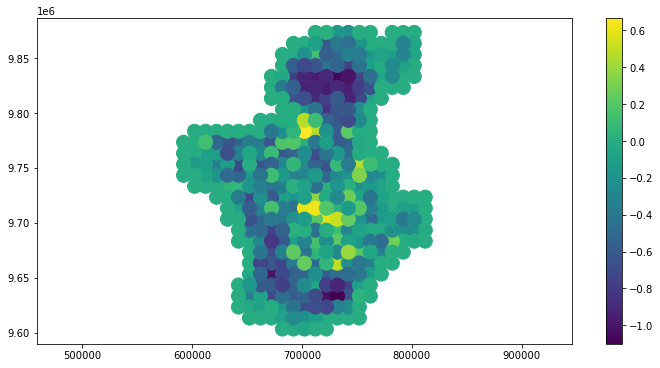

In [462]:

# dense grid for plotting
offset = 10
gridwidth = 3 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)
ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell
H = maximum_filter(H, size=1)

xx = xx[H>0]
yy = yy[H>0]

px_grid = np.array([xx.flatten(), yy.flatten()])
pX_grid=px_grid.T


#mean_list, var_list = vgp.get_marginal(px_grid.T)
mean_list, var_list = vgp.get_marginal(x_grid[None])

#mean, var = vgp.get_conditional(x_grid)

#mean_list = tf.split(mean[0],2,axis=0)
        
len_grid = (tf.math.softplus(vgp.mean_len) + tf.math.sigmoid(mean_list[0])).numpy()#0.0+tf.math.exp(vgp.mean_len+mean_list[0]).numpy() #+ 0.0*var_list[0].numpy()
var_grid = (tf.math.softplus(vgp.mean_amp) + tf.math.sigmoid(mean_list[1])).numpy()#0.0+tf.math.exp(vgp.mean_len+mean_list[0]).numpy() #+ 0.0*var_list[0].numpy()


len_grid = 0.0+(vgp.mean_len+mean_list[0]).numpy() #+ 0.0*var_list[0].numpy()
var_grid = 0.0+(vgp.mean_amp+mean_list[1]).numpy() #+ 0.0*var_list[0].numpy()

#var_grid = tf.math.exp(vgp.mean_amp+mean_list[1]).numpy()**0.5
plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,c=(var_grid),cmap='viridis',marker='o',s=200)#,vmax=20)#vmin,vmax
plt.axis('equal')
plt.colorbar()
plt.show()

plt.scatter((x_grid[:,0]+xmean)*1000+0000,(x_grid[:,1]+ymean)*1000,c=(len_grid),cmap='viridis',marker='o',s=200)#,vmax=3.19,vmin=2.05)#vmin,vmax
plt.colorbar()
plt.axis('equal')
plt.show()



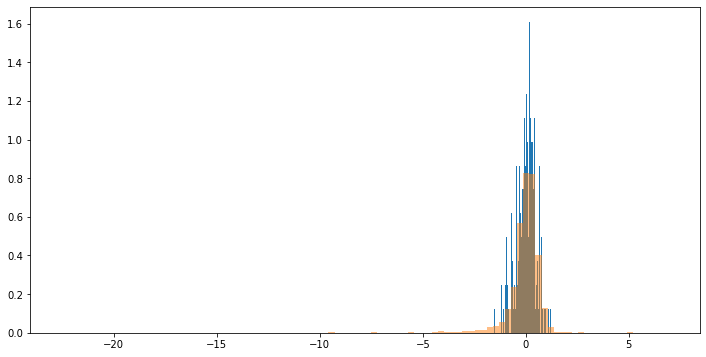

In [93]:
plt.hist(mean_list[0].numpy()[:,0],bins=100,density=True)
#plt.show()
plt.hist(pmean_list[0].numpy()[:,0],bins=100,alpha=0.5,density=True)
plt.show()

In [66]:
# loss = vgp.optimize(BATCH_SIZE, SEG_LENGTH, NUM_EPOCHS=1000)
mean_list[0].shape

TensorShape([295, 1])

In [962]:
#vgp.trainable_variables

In [283]:
print(tfd.kl_divergence(vgp.variational_inducing_observations_posterior,vgp.inducing_prior) )
        
#         if self.kernel_len_priors is not None:
#             for prior,var in zip(self.kernel_len_priors,self.kernel_len.trainable_variables):
#                 penalty -= prior.log_prob(var)
                
#         if self.kernel_amp_priors is not None:
#             for prior,var in zip(self.kernel_amp_priors,self.kernel_amp.trainable_variables):
#                 penalty -= prior.log_prob(var)

tf.Tensor([325.41434878], shape=(1,), dtype=float64)


In [97]:
i=0
for d in dataset:
    predictor_values = d[2]
    len_vals, amp_vals = vgp.get_samples(predictor_values,S=vgp.num_parallel_samples)   
    print(i,len_vals.numpy().mean(axis=0).max())
    #if i==1: 
    break
    i+=1#print(vgp.surrogate_posterior_expected_log_likelihood(d[1],d[0],d[1]).numpy())

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]

In [849]:
len_vals.shape

TensorShape([10, 16, 100, 1])

In [850]:
len_vals.numpy().mean(axis=0).max(axis=1)

array([[5.08754923],
       [4.11685504],
       [3.4262846 ],
       [4.88287137],
       [5.09743749],
       [5.07934402],
       [5.13361151],
       [4.66815922],
       [4.57528312],
       [4.48488502],
       [5.11387361],
       [5.1697415 ],
       [5.02767315],
       [5.03646608],
       [4.85174329],
       [3.98915664]])

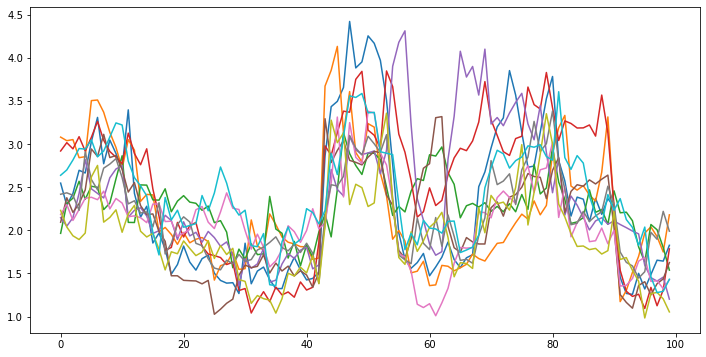

In [944]:
len_vals.numpy().mean(axis=0)[0]

for i in range(10):
    plt.plot(len_vals.numpy()[i][0,:,0])
plt.show()

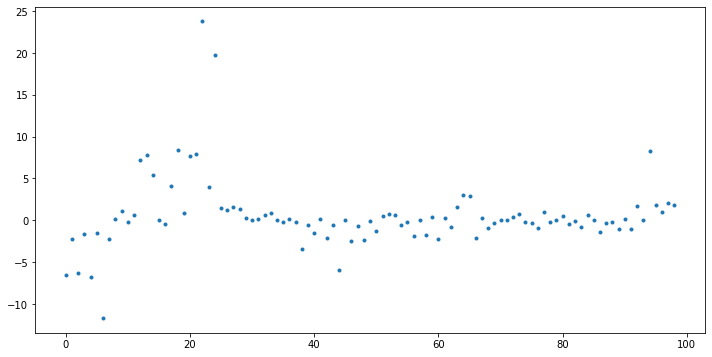

In [526]:
plt.plot(np.diff(d[1][0,:,0].numpy()),'.')

In [524]:
np.diff(d[1][0].numpy())

array([], shape=(100, 0), dtype=float64)

In [450]:
locations = d[1]
time_points = d[0]
predictor_values = d[1]

In [449]:
for d in dataset:
    time_points = d[0]
    break
    #aa = locations.numpy()
    cc = time_points.numpy()
    for i in range(16):
        bb= cc[i]
        #print(np.linalg.norm(np.diff(bb,axis=0),axis=-1).max())
        #print(np.diff(bb,axis=0).max())

In [938]:
#cc[1]
vgp.jitter

1e-06

In [448]:
for tt in allT:
    print(tt.max(),np.diff(tt,axis=0).max())

25567.516666666666 48.0
13170.016666666666 120.0
15378.016666666666 24.016666666666424
8478.516666666666 108.5
22771.016666666666 48.0
8010.016666666666 24.016666666666424
13434.0 24.0
24787.0 16.5
46570.0 144.0
42817.38333333333 144.01666666666642
41778.01666666667 160.25
31943.5 8.016666666666424
56330.5 48.0
56258.5 16.016666666666424
39101.78333333333 48.0
56298.5 16.0
33804.15 8.016666666670062
56270.5 28.016666666670062
35183.5 16.0
31245.85 8.016666666666424
56270.5 48.0
52259.183333333334 67.0
42897.0 24.016666666670062
35255.5 8.016666666670062
34318.23333333333 9.216666666659876
54582.5 16.016666666670062
56290.5 48.0
56330.5 16.016666666670062
56286.5 15.983333333329938
56306.5 47.0
53146.5 72.0
37554.5 56.0
48287.916666666664 12.0
56334.51666666667 120.0
55658.5 23.0
56258.5 24.53333333333285
56330.5 8.016666666670062
56338.5 52.0


In [449]:
24463-378

24085

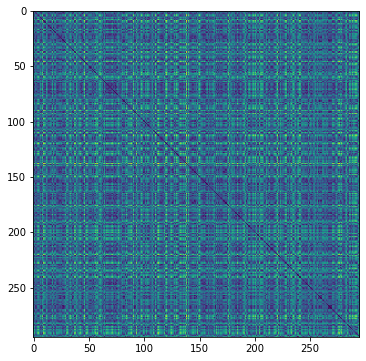

In [937]:
#for p in allT[0]: print(p)

A = vgp.inducing_index_points#tf.constant([[1, 1], [2, 2], [3, 3]])
r = tf.reduce_sum(A*A, 1)

# turn r into column vector
r = tf.reshape(r, [-1, 1])
D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)

A
plt.imshow(tf.sqrt(D+1e-3).numpy())
#np.diagonal(tf.sqrt(D+1e-9).numpy())

In [922]:
vgp.inducing_index_points

<tf.Variable 'ind_points:0' shape=(295, 2) dtype=float64, numpy=
array([[ -34.17418727,   25.22118373],
       [  16.12905525,  -75.98907394],
       [  15.2842243 ,   44.68126999],
       [  33.34019419,  -23.86776244],
       [ -34.89394878, -116.10758317],
       [ -15.05770849,  -73.64479124],
       [  25.60596968,   74.41522827],
       [  15.92575513,    5.5105558 ],
       [  54.55126792,   93.36637461],
       [ -15.35351991, -113.91873474],
       [ -45.9681855 ,  -75.46663462],
       [ -34.32884983,  -53.55149918],
       [  26.10392992,  114.28603   ],
       [  -6.40604885,  -34.15421328],
       [  17.90833002,  -34.19429998],
       [ -46.44284704,  -45.59434479],
       [ -45.1762328 ,  -14.29119085],
       [  32.96313003,   84.83933844],
       [ -45.03881896,  -53.26964306],
       [ -35.71174552,   45.25742839],
       [  15.77317932,   56.70545806],
       [ -24.45151231,  -65.99703501],
       [ -14.97050399,  -24.04147467],
       [  36.81558435,  -44.76730739],

In [921]:
kernel_len.matrix(vgp.inducing_index_points,vgp.inducing_index_points)

<tf.Tensor: shape=(295, 295), dtype=float64, numpy=
array([[0.48144709, 0.15681402, 0.28409082, ..., 0.2049096 , 0.12675636,
        0.28281401],
       [0.15681402, 0.48144709, 0.14534642, ..., 0.12586288, 0.29590477,
        0.13099809],
       [0.28409082, 0.14534642, 0.48144709, ..., 0.34722518, 0.14430416,
        0.16692109],
       ...,
       [0.2049096 , 0.12586288, 0.34722518, ..., 0.48144709, 0.14132273,
        0.12038692],
       [0.12675636, 0.29590477, 0.14430416, ..., 0.14132273, 0.48144709,
        0.0922524 ],
       [0.28281401, 0.13099809, 0.16692109, ..., 0.12038692, 0.0922524 ,
        0.48144709]])>

In [915]:
len_vals, amp_vals = vgp.get_samples(predictor_values,S=vgp.num_parallel_samples)   
K = vgp.non_stat_vel(time_points, len_vals, amp_vals) # BxNxN
K = K + (tf.eye(tf.shape(K)[-1], dtype=tf.float64) * ((tf.nn.softplus(vgp.vgp_observation_noise_variance))+vgp.jitter))

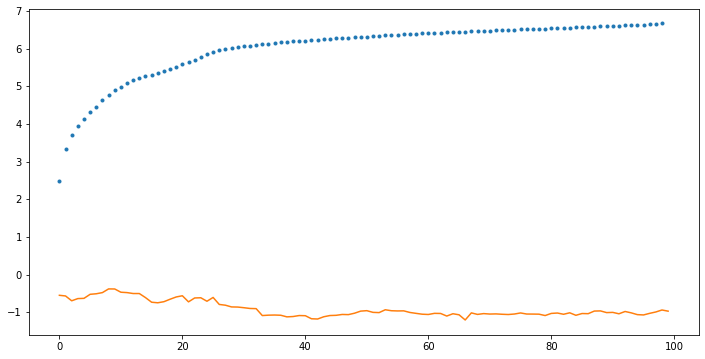

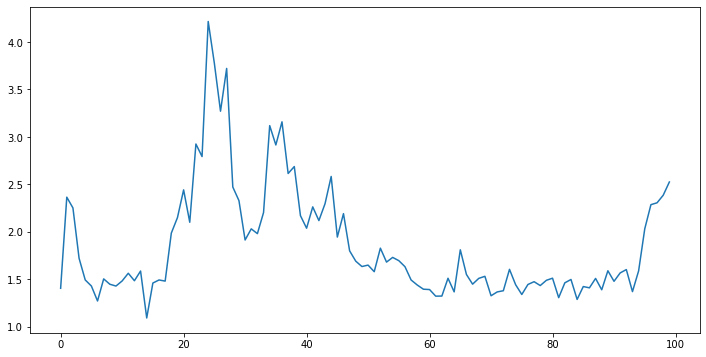

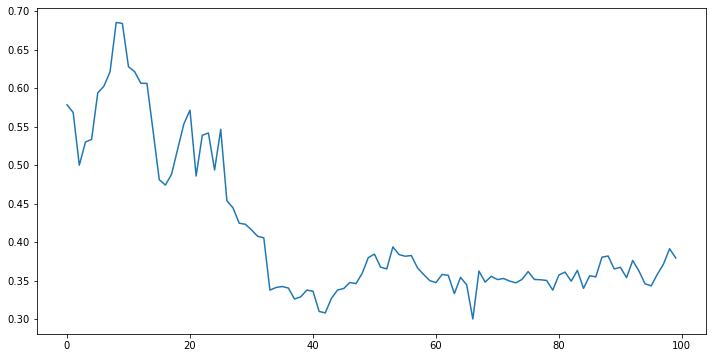

In [916]:
plt.plot(np.log(np.diagonal(K.numpy()[0,0])),'.')
plt.plot(np.log(amp_vals.numpy()[0,0,:,0]**0.5))
plt.show()
plt.plot((len_vals.numpy()[0,0,:,0]))
plt.show()
plt.plot((amp_vals.numpy()[0,0,:,0]**0.5))


In [383]:
(len_vals.numpy()[0,0,:,0])

array([2.17947450e+00, 2.10866736e+00, 1.47042075e+00, 1.19530928e+00,
       7.79124999e-01, 7.33711564e-01, 9.37554382e-01, 8.16848351e-01,
       8.49558376e-01, 8.54805153e-01, 6.03610242e-01, 3.70172293e-01,
       2.30692131e-01, 2.23006114e-01, 1.64251003e-01, 1.59848395e-01,
       6.14322292e-02, 2.06553506e-02, 1.01541872e-02, 1.04317302e-02,
       1.45517966e-02, 8.56715845e-03, 2.87979232e-03, 2.86216228e-03,
       2.18124004e-03, 2.31182818e-03, 2.29172657e-03, 1.87842124e-03,
       7.80738767e-05, 4.30606796e-06, 5.93364843e-06, 6.38239434e-06,
       8.52408264e-06, 9.30748805e-06, 7.28370146e-05, 3.72904412e-04,
       1.50738183e-03, 1.58490977e-03, 2.19563750e-02, 4.23423171e-02,
       4.57275995e-02, 4.53795406e-02, 5.11474461e-02, 4.80448427e-02,
       5.35675269e-02, 6.25143646e-02, 9.89985167e-03, 4.17132513e-03,
       4.84363216e-03, 9.44390499e-03, 3.03229822e-02, 1.58791405e-01,
       1.55272409e-01, 1.27406419e-01, 1.91368612e-01, 2.25159113e-01,
      

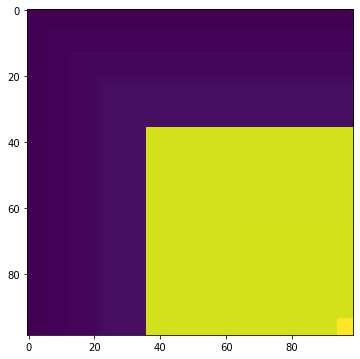

In [786]:
L = tf.linalg.cholesky(K)
#L[0]
plt.imshow(K.numpy()[0,0])

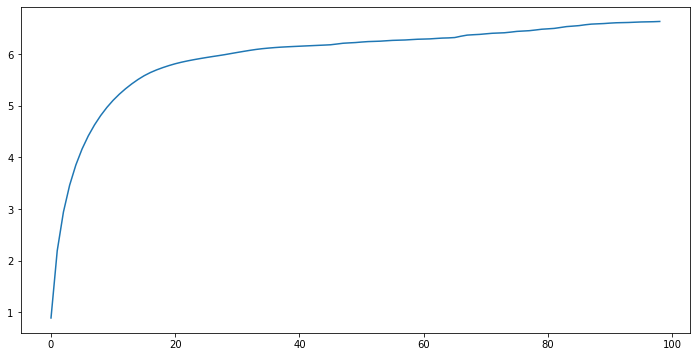

In [397]:
plt.plot(np.log(np.diagonal(K.numpy()[0,0])))

In [787]:
tfd.MultivariateNormalTriL(scale_tril = L).log_prob(centered_locations[...,0])

<tf.Tensor: shape=(10, 16), dtype=float64, numpy=
array([[-208.42065339, -209.09151376, -169.65900264, -227.87717856,
        -239.1288034 , -234.94403281, -240.4309205 , -166.86606216,
        -212.47810302, -216.11374239, -217.12699039, -212.44537744,
        -224.54121167, -242.4541499 , -205.96733732, -160.63896339],
       [-208.35292887, -206.17525341, -173.92066934, -230.29258913,
        -239.88699265, -236.57491662, -241.59798161, -168.06523019,
        -209.42588558, -218.23936393, -217.58943897, -217.04474137,
        -226.1009365 , -239.94283279, -202.24827826, -157.15803159],
       [-202.9686935 , -207.73316957, -172.89103818, -232.30526008,
        -241.71708335, -234.17576728, -241.70482422, -164.58484617,
        -213.63372762, -218.78977181, -215.7350554 , -215.14461725,
        -224.90670035, -242.05324151, -204.76272227, -158.35731066],
       [-202.26649222, -208.30875251, -170.96939018, -234.16018023,
        -241.14383203, -234.5080838 , -241.02834104, -167.42149

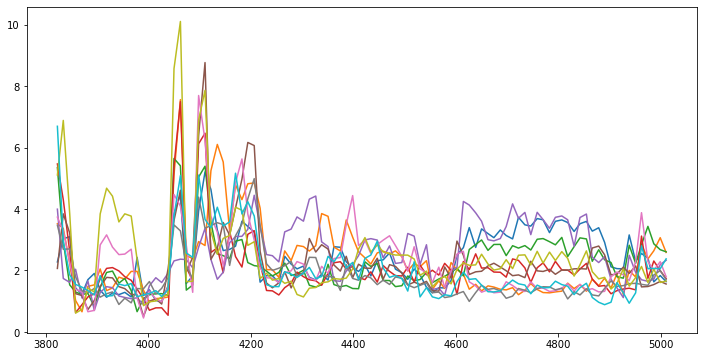

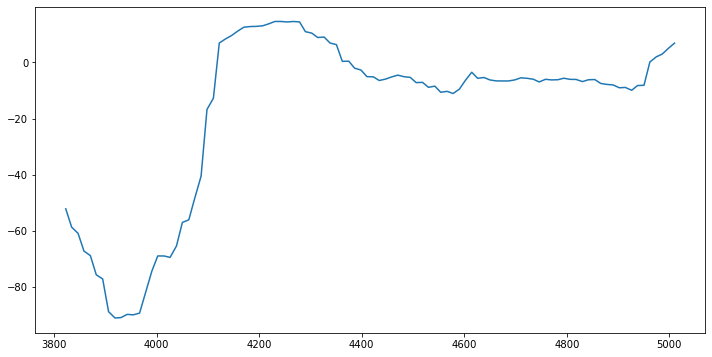

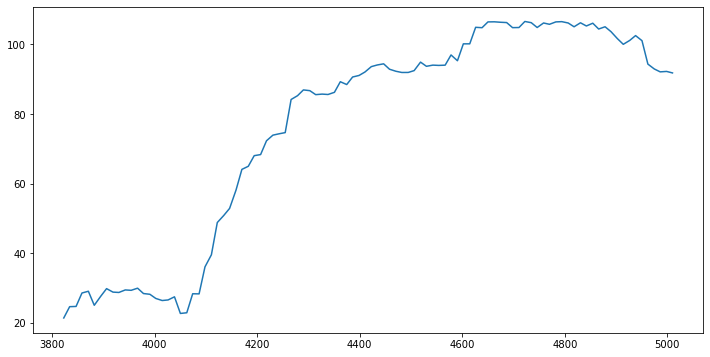

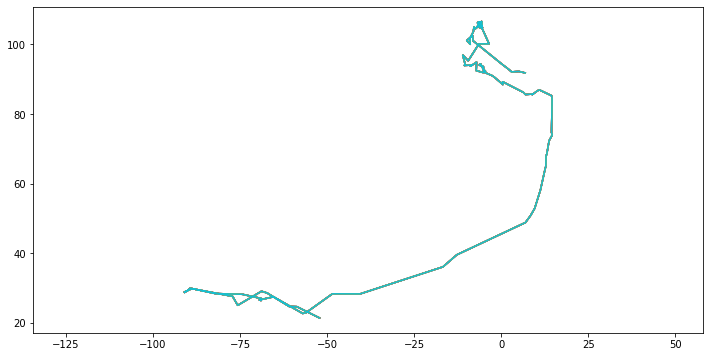

In [896]:
aa = len_vals.numpy()
for i in range(10):
    plt.plot(time_points.numpy()[0,:,0],aa[i,0,:,0])
plt.show()


plt.plot(time_points.numpy()[0,:,0],locations.numpy()[0,:,0])
plt.show()

plt.plot(time_points.numpy()[0,:,0],locations.numpy()[0,:,1])
plt.show()
for i in range(10):
    plt.plot(locations.numpy()[0,:,0],locations.numpy()[0,:,1])#aa[i,0,:,0])
plt.axis('equal')
plt.show()

In [828]:



        
centered_locations = locations[...,1:,:]-locations[...,0,None,:] #centered observations

logpdf_K_x = tfd.MultivariateNormalTriL(scale_tril = tf.linalg.cholesky(K[0,0])).log_prob((centered_locations[0,...,0]))#,axis=0)
logpdf_K_y = tf.reduce_sum(tf.reduce_mean(tfd.MultivariateNormalTriL(scale_tril = tf.linalg.cholesky(K)).log_prob((centered_locations[...,0])),axis=0))
logpdf_K_x
        #return logpdf_K_x + logpdf_K_y   

<tf.Tensor: shape=(), dtype=float64, numpy=-208.42065339339496>

In [829]:
tf.reduce_sum(tfp.distributions.Normal(loc=0,scale=1).log_prob(tf.linalg.matmul(tf.linalg.inv(tf.linalg.cholesky(K[0,0])),tf.expand_dims(centered_locations[0,...,0],-1)).numpy()[:,0]))

<tf.Tensor: shape=(), dtype=float32, numpy=-148.45468>

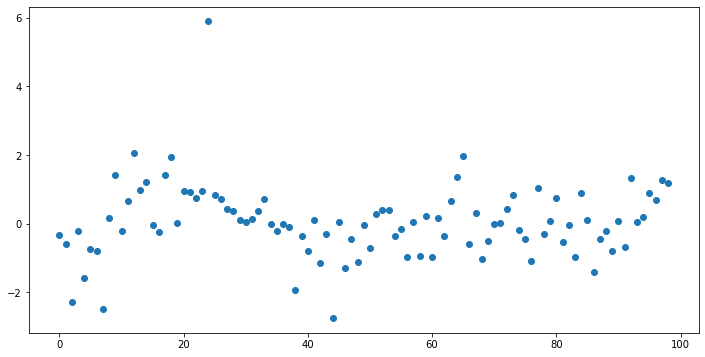

In [816]:
plt.plot(tf.linalg.matmul(tf.linalg.inv(tf.linalg.cholesky(K[0,0])),tf.expand_dims(centered_locations[0,...,0],-1)).numpy()[:,0],'o')

In [818]:
tfp.distributions.Normal(loc=0,scale=1).log_prob(tf.linalg.matmul(tf.linalg.inv(tf.linalg.cholesky(K[0,0])),tf.expand_dims(centered_locations[0,...,0],-1)).numpy()[:,0])

<tf.Tensor: shape=(99,), dtype=float32, numpy=
array([ -0.97681785,  -1.0891817 ,  -3.5473366 ,  -0.9390855 ,
        -2.1880345 ,  -1.1896629 ,  -1.2452439 ,  -3.9872594 ,
        -0.93404704,  -1.9036818 ,  -0.9404044 ,  -1.1302764 ,
        -3.052103  ,  -1.4040719 ,  -1.6563674 ,  -0.91971064,
        -0.9516462 ,  -1.9279022 ,  -2.826162  ,  -0.9189591 ,
        -1.3614318 ,  -1.3387157 ,  -1.2012374 ,  -1.3653266 ,
       -18.280106  ,  -1.2724743 ,  -1.1866562 ,  -1.0043143 ,
        -0.98887694,  -0.92484593,  -0.91951114,  -0.92670953,
        -0.9873166 ,  -1.1804698 ,  -0.91894835,  -0.94061655,
        -0.918939  ,  -0.92501277,  -2.7674477 ,  -0.97988343,
        -1.2454627 ,  -0.9233027 ,  -1.577415  ,  -0.9637219 ,
        -4.6984086 ,  -0.9198838 ,  -1.7640654 ,  -1.0229808 ,
        -1.5367603 ,  -0.9196663 ,  -1.1790116 ,  -0.9616217 ,
        -1.0018125 ,  -0.99758255,  -0.9887819 ,  -0.9306441 ,
        -1.385589  ,  -0.91988295,  -1.359675  ,  -0.94184136,
        

In [819]:
tf.linalg.matmul(tf.linalg.inv(tf.linalg.cholesky(K[0,0])),tf.expand_dims(centered_locations[0,...,0],-1)).numpy()[:,0].argmax()

24

In [841]:
(tf.linalg.inv(tf.linalg.cholesky(K[0,0]))[24].numpy()*centered_locations[0,...,0].numpy())[:25].sum()

5.8925660408813165

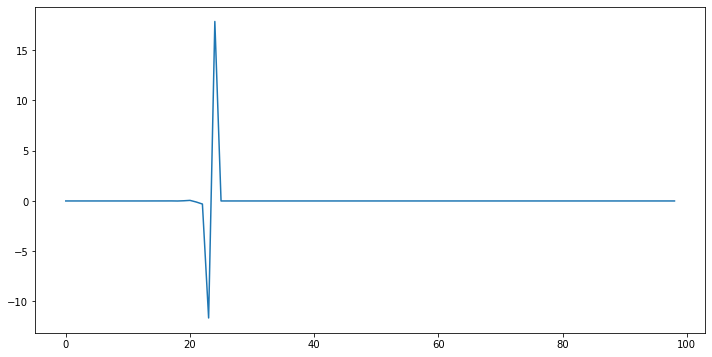

In [842]:
plt.plot((tf.linalg.inv(tf.linalg.cholesky(K[0,0]))[24].numpy()*centered_locations[0,...,0].numpy()))

In [805]:
logpdf_K_y

<tf.Tensor: shape=(), dtype=float64, numpy=-3386.5780421940617>

In [807]:
logpdf_K_x

<tf.Tensor: shape=(), dtype=float64, numpy=-208.42065339339496>

In [790]:
centered_locations[...,1]

<tf.Tensor: shape=(16, 99), dtype=float64, numpy=
array([[ 3.2455820e+00,  3.3136080e+00,  7.1713180e+00, ...,
         7.0687081e+01,  7.0809849e+01,  7.0380026e+01],
       [-4.7940900e-01, -1.2918800e-01, -9.0550500e-01, ...,
         5.7709170e+00,  6.1116620e+00,  4.8994530e+00],
       [-3.0433200e+00, -5.4569640e+00, -9.0701130e+00, ...,
        -5.0261000e-02,  1.2562600e-01,  1.5533900e-01],
       ...,
       [ 4.6563550e+00,  5.7620920e+00,  9.3937330e+00, ...,
        -1.4788078e+01, -1.4664572e+01, -1.4185434e+01],
       [-5.5820100e-01, -4.3401900e-01, -5.2723700e-01, ...,
         3.7502914e+01,  4.2379952e+01,  4.1224723e+01],
       [ 4.7768560e+00,  7.8428340e+00,  8.3271470e+00, ...,
         4.8850815e+01,  4.5106580e+01,  4.1052399e+01]])>

In [791]:
K.shape

TensorShape([10, 16, 99, 99])

In [789]:
logpdf_K_y

<tf.Tensor: shape=(), dtype=float64, numpy=-3423.413394796251>

In [292]:
centered_locations

<tf.Tensor: shape=(16, 99, 2), dtype=float64, numpy=
array([[[-6.53606310e+00,  3.24558200e+00],
        [-8.74252870e+00,  3.31360800e+00],
        [-1.50601050e+01,  7.17131800e+00],
        ...,
        [ 5.51550280e+01,  7.06870810e+01],
        [ 5.72618687e+01,  7.08098490e+01],
        [ 5.90557120e+01,  7.03800260e+01]],

       [[ 1.22674920e+00, -4.79409000e-01],
        [-2.32059800e-01, -1.29188000e-01],
        [ 2.55627760e+00, -9.05505000e-01],
        ...,
        [-1.77362861e+01,  5.77091700e+00],
        [-1.51253387e+01,  6.11166200e+00],
        [-1.58346767e+01,  4.89945300e+00]],

       [[-6.08652400e-01, -3.04332000e+00],
        [-1.62123350e+00, -5.45696400e+00],
        [-6.09522300e-01, -9.07011300e+00],
        ...,
        [ 3.48335989e+01, -5.02610000e-02],
        [ 3.49224799e+01,  1.25626000e-01],
        [ 3.49642498e+01,  1.55339000e-01]],

       ...,

       [[ 3.67568770e+00,  4.65635500e+00],
        [-7.21685200e-01,  5.76209200e+00],
        [

In [285]:
# loss = vgp.optimize(BATCH_SIZE, SEG_LENGTH, NUM_EPOCHS=1000)
# 
for d in dataset: break

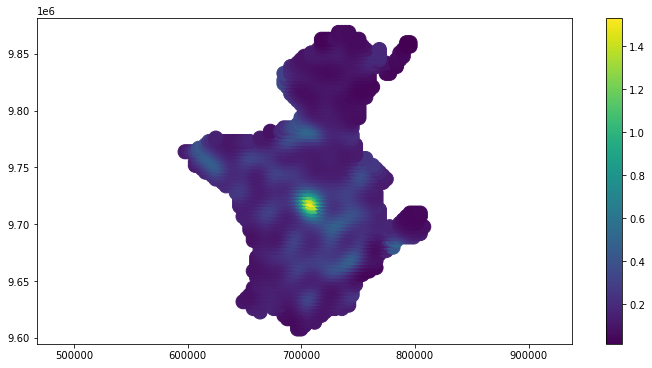

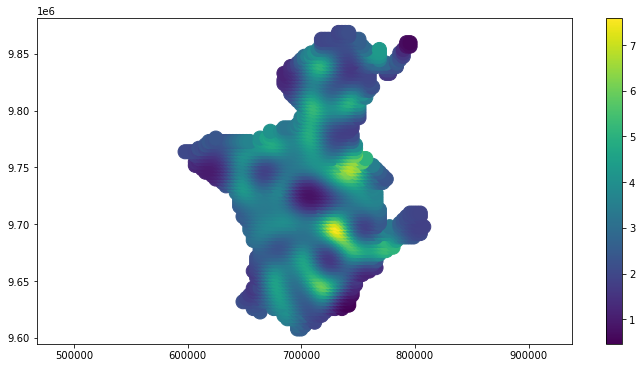

In [963]:

# dense grid for plotting
offset = 10
gridwidth = 3 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)
ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell
H = maximum_filter(H, size=1)

xx = xx[H>0]
yy = yy[H>0]

px_grid = np.array([xx.flatten(), yy.flatten()])
pX_grid=px_grid.T


mean_list, var_list = vgp.get_marginal(px_grid.T)
        
len_grid = (tf.math.softplus(vgp.mean_len) + tf.math.sigmoid(mean_list[0])).numpy()#0.0+tf.math.exp(vgp.mean_len+mean_list[0]).numpy() #+ 0.0*var_list[0].numpy()
var_grid = (tf.math.softplus(vgp.mean_amp) + tf.math.sigmoid(mean_list[1])).numpy()#0.0+tf.math.exp(vgp.mean_len+mean_list[0]).numpy() #+ 0.0*var_list[0].numpy()


len_grid = 0.0+tf.math.exp(vgp.mean_len+mean_list[0]).numpy() #+ 0.0*var_list[0].numpy()
var_grid = 0.0+tf.math.exp(vgp.mean_amp+mean_list[1]).numpy() #+ 0.0*var_list[0].numpy()

#var_grid = tf.math.exp(vgp.mean_amp+mean_list[1]).numpy()**0.5
plt.scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=(var_grid),cmap='viridis',marker='o',s=200)#,vmax=20)#vmin,vmax
plt.axis('equal')
plt.colorbar()
plt.show()

plt.scatter((px_grid[0]+xmean)*1000+0000,(px_grid[1]+ymean)*1000,c=(len_grid),cmap='viridis',marker='o',s=200)#,vmax=3.19,vmin=2.05)#vmin,vmax
plt.colorbar()
plt.axis('equal')
plt.show()



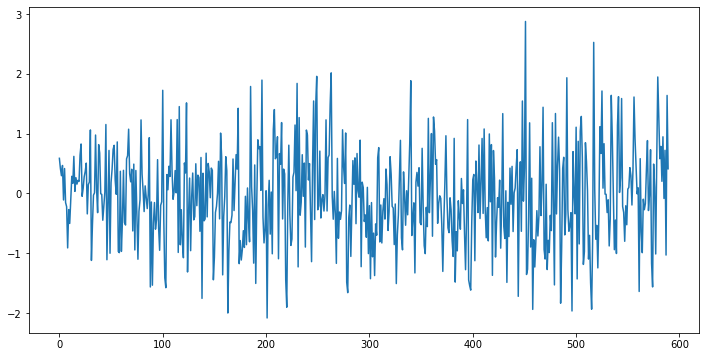

In [914]:
plt.plot(vgp.q_mu.numpy())

In [854]:
vgp.q_sqrt.to_dense()

<tf.Tensor: shape=(1, 936, 936), dtype=float64, numpy=
array([[[ 6.84167358e-01,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 4.55005085e-02,  1.03289573e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.05417382e-03, -2.80707068e-03,  9.93157575e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.00100795e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.60682638e-04,  9.98796046e-01,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          8.34916747e-05,  6.18022313e-04,  1.00035242e+00]]])>

In [21]:
tf.linalg.diag_part(vgp.q_sqrt.to_dense()).numpy().min()

0.15929019210484366

In [220]:
kernel_amp.length_scale

<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=13.896497255921519>

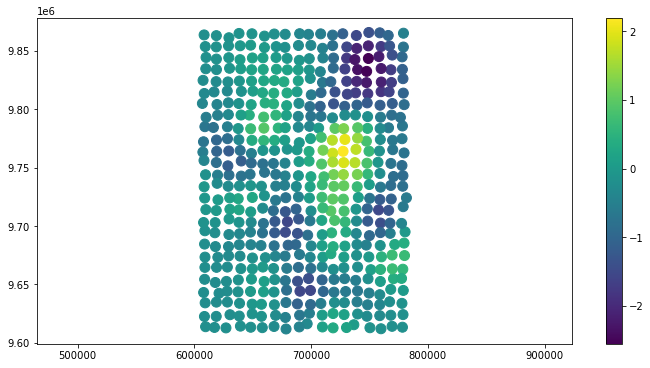

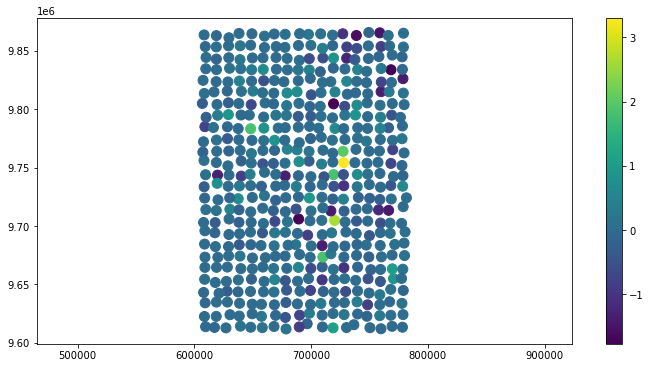

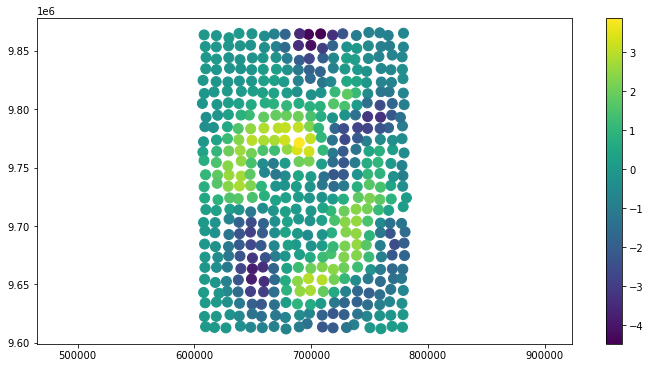

In [855]:
mean_list, var_list = vgp.get_marginal(x_grid)
        
len_grid = tf.math.exp(vgp.mean_len+mean_list[0]).numpy() #+ 0.0*var_list[0].numpy()
var_grid = (vgp.mean_amp+mean_list[1]).numpy()
plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,c=(var_grid),cmap='viridis',marker='o',s=100)#,vmax=10)#vmin,vmax
plt.axis('equal')
plt.colorbar()
plt.show()

plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,c=(vgp.q_mu.numpy()[936//2:]),cmap='viridis',marker='o',s=100)#,vmax=0.19,vmin=0.05)#vmin,vmax
plt.colorbar()
plt.axis('equal')
plt.show()

plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,c=(mean_list[0]),cmap='viridis',marker='o',s=100)#,vmax=0.19,vmin=0.05)#vmin,vmax
plt.colorbar()
plt.axis('equal')
plt.show()

792021.2389913904 9681395.809907746
800563.1043042991 9681132.54905945


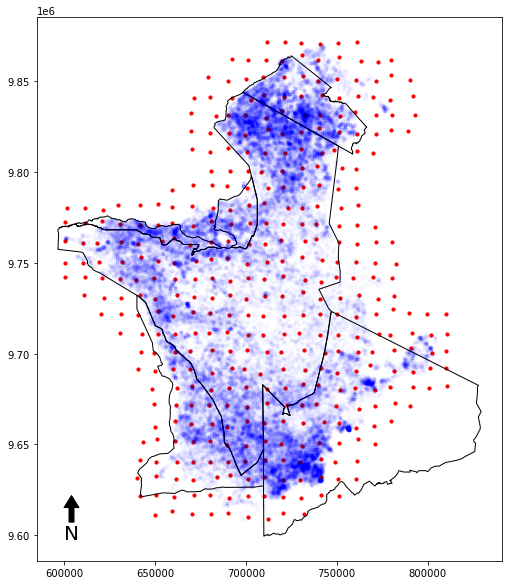

In [109]:
mean_list[0].numpy().argmax()

x_grid[367]

print((x_grid[367,0]+xmean)*1000,(x_grid[367,1]+ymean)*1000)
print((x_grid[12,0]+xmean)*1000,(x_grid[12,1]+ymean)*1000)

plt.figure(figsize=(10,10))
ax = plt.subplot()

dfpark = gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")

dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


ax.set_aspect('equal')
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


plt.plot((x+xmean)*1000,(y+ymean)*1000,'.',c='b',alpha=0.01)
plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=10,c='r')
plt.show()


In [69]:


Z = vgp.inducing_index_points 

kernel_amp = vgp.kernel_amp
kernel_len = vgp.kernel_len


q_sqrt = vgp.q_sqrt.to_dense()


M = tf.shape(vgp.q_mu)[0]

Kmm_amp = tf.linalg.LinearOperatorFullMatrix(kernel_amp.matrix(Z,Z) + 0*vgp.jitter * tf.eye(M//2, dtype=tf.float64),is_positive_definite=True,is_self_adjoint=True)
Kmm_len = tf.linalg.LinearOperatorFullMatrix(kernel_len.matrix(Z,Z) + 0*vgp.jitter * tf.eye(M//2, dtype=tf.float64),is_positive_definite=True,is_self_adjoint=True)
Kmm = tf.linalg.LinearOperatorBlockDiag([Kmm_len,Kmm_amp])


Kmn_amp = tf.linalg.LinearOperatorFullMatrix(kernel_amp.matrix(Z, Z)+ 0*vgp.jitter * tf.eye(M//2, dtype=tf.float64),is_positive_definite=True,is_self_adjoint=True)
Kmn_len = tf.linalg.LinearOperatorFullMatrix(kernel_len.matrix(Z, Z)+ 0*vgp.jitter * tf.eye(M//2, dtype=tf.float64),is_positive_definite=True,is_self_adjoint=True)
Kmn = tf.linalg.LinearOperatorBlockDiag([Kmn_len,Kmn_amp])


Knn_amp = tf.linalg.LinearOperatorFullMatrix(kernel_amp.matrix(Z, Z)+ 0*vgp.jitter * tf.eye(M//2, dtype=tf.float64),is_positive_definite=True,is_self_adjoint=True)
Knn_len = tf.linalg.LinearOperatorFullMatrix(kernel_len.matrix(Z, Z)+ 0*vgp.jitter * tf.eye(M//2, dtype=tf.float64),is_positive_definite=True,is_self_adjoint=True)
Knn = tf.linalg.LinearOperatorBlockDiag([Knn_len,Knn_amp])

mean, var = marginal(Kmn.to_dense(),Kmm.to_dense(),Knn.to_dense(),vgp.q_mu,q_sqrt)


q_mu = tf.expand_dims(vgp.q_mu,-1)
Lm = tf.linalg.cholesky(Kmm.to_dense())

#Knn = tf.linalg.diag_part(Knn.to_dense())

N = tf.shape(Kmn.to_dense())[-1]
M = tf.shape(q_mu)[0]

# Compute the projection matrix A
Lm = tf.broadcast_to(Lm, tf.shape(Lm))
A = tf.linalg.triangular_solve(Lm, Kmn.to_dense(), lower=True)  # [..., M, N]




A = tf.linalg.cholesky(Kmm.to_dense())

fmean = tf.linalg.matmul(A, q_mu, transpose_a=False)  # [..., N, R]
mean_list = tf.split(fmean,2,axis=0)

tf.reduce_sum(mean_list[0])
#var_list = tf.split(var,2,axis=0)

<tf.Tensor: shape=(), dtype=float64, numpy=-4.044838903744084>

In [83]:
A = tf.linalg.cholesky(Kmm_len.to_dense())
fmean = tf.linalg.matmul(A, q_mu[:390], transpose_a=False)  # [..., N, R]
qlen = q_mu[:390]

In [107]:
qlen[12]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([3.79079019])>

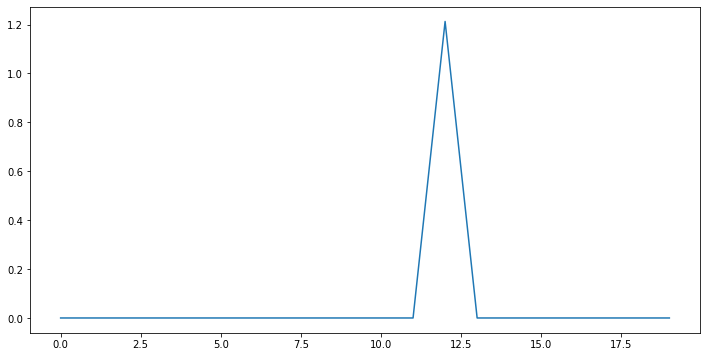

In [100]:
for i in range(367,368):
    bb= (A[i]*qlen[:,0]).numpy()

plt.plot(bb[:20])
plt.show()

In [103]:
bb[12]
Z[12]

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 94.79252156, -55.23685731])>

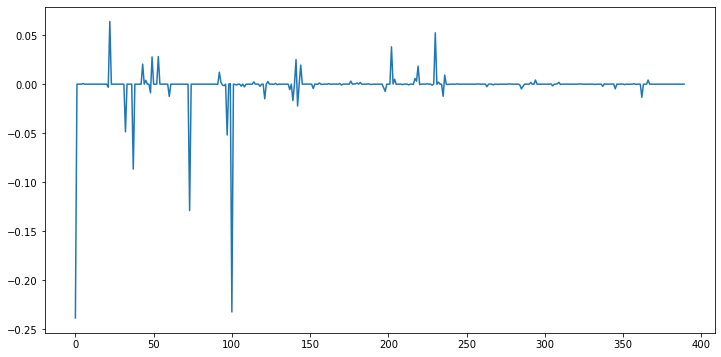

In [90]:
bb= (A[366]*qlen[:,0]).numpy()

plt.plot(bb)

In [88]:
tf.reduce_sum(A[367]*qlen[:,0])

<tf.Tensor: shape=(), dtype=float64, numpy=2.319955514951939>

In [81]:
fmean[367]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([2.31995551])>

In [73]:
aa = tf.reduce_sum(A,axis=-1).numpy()

In [75]:
aa[367]

0.3843361764231305

In [57]:
def marginal( Kmn, Kmm, Knn, q_mu, q_sqrt):
   
    q_mu = tf.expand_dims(q_mu,-1)

    Knn = tf.linalg.diag_part(Knn)
    Lm = tf.linalg.cholesky(Kmm)

    N = tf.shape(Kmn)[-1]
    M = tf.shape(q_mu)[0]

    # Compute the projection matrix A
    Lm = tf.broadcast_to(Lm, tf.shape(Lm))
    A = tf.linalg.triangular_solve(Lm, Kmn, lower=True)  # [..., M, N]

    # compute the covariance due to the conditioning
    fvar = Knn - tf.reduce_sum(tf.square(A), -2)  # [..., N]

    # construct the conditional mean
    f_shape = [M, 1]
    f = tf.broadcast_to(q_mu, f_shape)  # [..., M, R]
    fmean = tf.linalg.matmul(A, f, transpose_a=True)  # [..., N, R]

    L = tf.linalg.band_part(q_sqrt, -1, 0)  

    LTA = tf.linalg.matmul(L, A, transpose_a=True)  # [R, M, N]

    fvar = fvar + tf.reduce_sum(tf.square(LTA), -2)  # [R, N]
    fvar = tf.linalg.adjoint(fvar)  # [N, R]

    return fmean, fvar

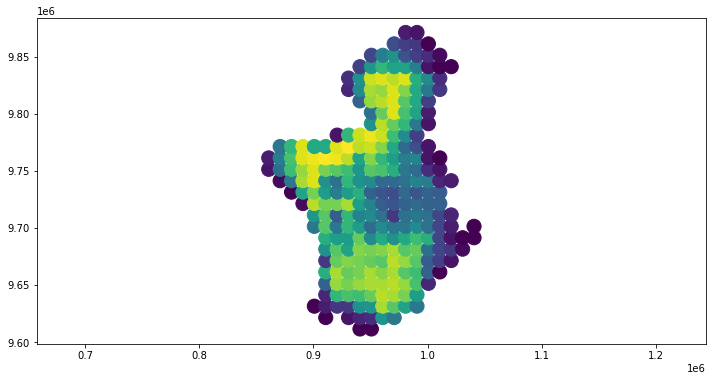

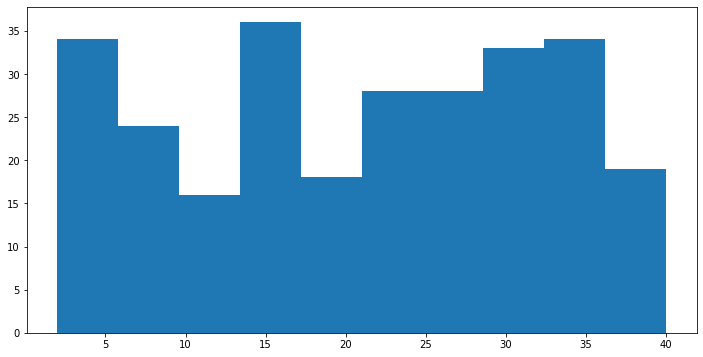

2.0


In [201]:
# Set up the grid - previous code
offset = 0
gridwidth = 10 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)


counts = np.zeros((np.unique(ID).shape[0],gridy.shape[0]-1,gridx.shape[0]-1))

for wid in np.unique(ID):
    x_w = x[ID==wid]
    y_w = y[ID==wid]
    if x_w.shape[0]>SEG_LENGTH:
        H, yedges, xedges = np.histogram2d(y_w, x_w,bins=[gridy,gridx])
    H[H>0] = 1
    counts[wid]=H
    #print(H.shape)

counts = np.sum(counts,axis=0)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell or a neighbouring cell
H = maximum_filter(H, size=0)

xx = xx[counts>1]
yy = yy[counts>1]
counts = counts[counts>1]


x_grid = np.array([xx.flatten(), yy.flatten()])
x_grid = x_grid


plt.scatter((x_grid[0]+xmean)*1000+250000,(x_grid[1]+ymean)*1000,c=(counts.reshape(-1,1)),cmap='viridis',marker='o',s=200)#,vmax=0.19,vmin=0.05)#vmin,vmax
plt.axis('equal')
# num_inducing_points_ = x_grid.shape[0]
plt.show()
plt.hist(counts)
plt.show()
print(counts.min())
# np.random.shuffle(x_grid)

# x_grid += np.random.normal(scale=0.1*gridwidth,size=x_grid.shape)
# num_inducing_points_

# x_grid.shape

In [185]:
counts.shape

(27, 22)

In [158]:
ID.shape

(92403,)

In [588]:
offset = 5
gridwidth = 10 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

In [593]:
dists = df.dist.values/df.steptime.values

In [594]:
np.nanmax(dists)

45449.5984

In [595]:
np.isfinite(dists)

array([ True,  True,  True, ...,  True,  True, False])

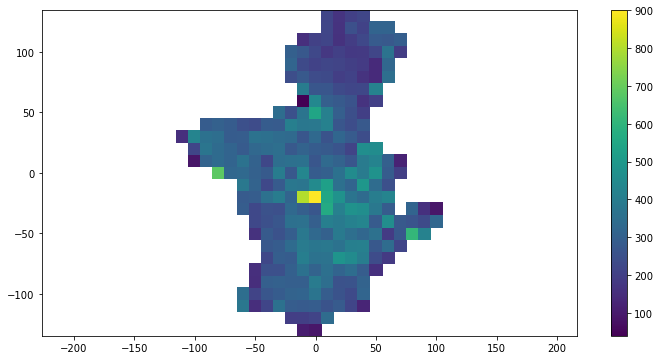

In [596]:
H, xedges, yedges, binnumber = stats.binned_statistic_2d(x[np.isfinite(dists)], y[np.isfinite(dists)], values = dists[np.isfinite(dists)], statistic='mean' , bins = [xedges, yedges])


XX, YY = np.meshgrid(xedges, yedges)


plt.pcolormesh(XX,YY,H.T)#,vmax=5000)

plt.colorbar()
plt.axis('equal')
plt.show()

In [597]:
G = H
G[np.isnan(G)]=0

print(G.max())
G.argmax()//G.shape[1]



901.5249468175238


11

In [600]:
G[11][11]

901.5249468175238

In [582]:
xedges[23]

2.5

In [580]:
yedges[3]

-117.5

In [611]:
x1 = (xedges[11])#+xmean)*1000
x2 = (xedges[12])#+xmean)*1000
y1 = (yedges[11])#+ymean)*1000
y2 = (yedges[12])#+ymean)*1000

df[((x>x1) & (x<x2) & (y>y1) & (y<y2))].iloc[39]

AID                            W55
x                      703016.3351
y                      9711893.359
Date               12/17/2018 9:00
migrant                          1
SPECIES                         WB
COLLAR_ID                 T5H-5587
OWNER                     HOPCRAFT
SEX                              F
year                          2018
month                           12
AdminArea                Serengeti
Grumeti                          0
livestock                        0
dist                   11457.78514
steptime                       1.5
abs.angle                 1.867871
rel.angle                 1.917582
Edge                      29.76848
Village_Dist           52899.07813
Tourism_fpt               0.031228
Rangerpost_Dist          16.643565
Temp                      25.44343
ID                              21
Name: 92478, dtype: object

In [612]:
df55 = df[df.AID=='W55']

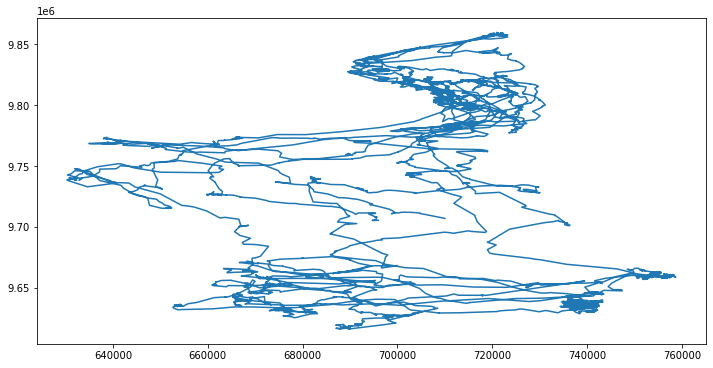

In [614]:
plt.plot(df55.x,df55.y)

In [615]:
df55

AID            x            y              Date  migrant SPECIES  \
87442   W55  695954.1473  9705356.462    5/28/2016 3:30        1      WB   
87443   W55  695919.9105  9705367.127    5/28/2016 7:30        1      WB   
87444   W55  695670.5396  9705337.294   5/28/2016 11:30        1      WB   
87445   W55  695097.6694  9705231.729   5/28/2016 19:30        1      WB   
87446   W55  694682.1359  9705343.901    5/29/2016 3:30        1      WB   
...     ...          ...          ...               ...      ...     ...   
92479   W55  704695.5066  9711290.413  12/17/2018 11:00        1      WB   
92480   W55  704776.7428  9711322.696  12/17/2018 13:00        1      WB   
92481   W55  704769.3491  9710907.111  12/17/2018 15:00        1      WB   
92482   W55  705707.6262  9710259.331  12/17/2018 17:00        1      WB   
229453  W55  710001.5073  9706928.504  12/18/2018 11:11        1      WB   

       COLLAR_ID     OWNER SEX  year  ...         dist steptime  abs.angle  \
87442   T5H-5587  HOPCRAFT   F  2016  ...    35.859513      4.0   2.839609   
87443   T5H-5587  HOPCRAFT   F  2016  ...   251.149056      4.0  -3.022525   
87444   T5H-5587  HOPCRAFT   F  2016  ...   582.515375      8.0  -2.959364   
87445   T5H-5587  HOPCRAFT   F  2016  ...   430.407425      8.0   2.877932   
87446   T5H-5587  HOPCRAFT   F  2016  ...    47.267034      4.0  -1.771159   
...          ...       ...  ..   ...  ...          ...      ...        ...   
92479   T5H-5587  HOPCRAFT   F  2018  ...    87.416029      2.0   0.378268   
92480   T5H-5587  HOPCRAFT   F  2018  ...   415.651072      2.0  -1.588585   
92481   T5H-5587  HOPCRAFT   F  2018  ...  1140.167861      2.0  -0.604249   
92482   T5H-5587  HOPCRAFT   F  2018  ...   359.755840      1.5  -2.183004   
229453  T5H-5030  HOPCRAFT   F  2018  ...          NaN      NaN        NaN   

        rel.angle       Edge  Village_Dist  Tourism_fpt  Rangerpost_Dist  \
87442   -1.852503  26.180025   47909.42188     0.049695         9.405570   
87443    0.421051  26.206557   47909.42188     0.049695         9.422505   
87444    0.063162  26.308202   47668.12891     0.052038         9.444022   
87445   -0.445890  26.517864   46944.78125     0.061149         9.482799   
87446    1.634095  26.835420   46703.85938     0.065002         9.712255   
...           ...        ...           ...          ...              ...   
92479    1.538387  28.869833   53918.92188     0.027399        16.702512   
92480   -1.966854  28.889174   53918.92188     0.027399        16.765904   
92481    0.984336  28.479708   54155.44922     0.027287        16.386743   
92482   -1.578755  27.706193   55192.83984     0.025419        16.245110   
229453        NaN  24.167832   59750.51953     0.020228        16.366779   

             Temp  ID  
87442   17.523080  21  
87443   22.249109  21  
87444   25.380273  21  
87445   20.382776  21  
87446   17.268747  21  
...           ...  ..  
92479   25.911386  21  
92480   24.660989  21  
92481   20.267068  21  
92482   19.048624  21  
229453  25.416193  21  

[5042 rows x 24 columns]

In [618]:

for wid in np.unique(df.AID.values):
    
    wdf = df[df.AID==wid]
    print(wid, np.unique(wdf.COLLAR_ID.values))
#     print(np.nanmean(dists[ID==wid]/steptime[ID==wid]),dists[ID==wid].std(), np.nanmean(steptime[ID==wid]),dists[ID==wid].std())
    
#     plt.hist((angles[ID==wid]),bins=50,range=[0,3.142],density=True)#,alpha=0.5,c='b')
#     plt.title(str(wid))
#     plt.show()

W27 ['T5H-2175']
W28 ['T5H-2409']
W30 ['T5H-1805']
W31 ['T5H-1861']
W33 ['T5H-1806']
W34 ['T5H-1804']
W35 ['T5H-1857']
W36 ['T5H-5031']
W37 ['T5H-5030']
W39 ['T5H-5028']
W40 ['T5H-2409']
W41 ['T5H-5570']
W42 ['T5H-5571']
W43 ['T5H-5572']
W44 ['T5H-5573']
W45 ['T5H-5574']
W46 ['T5H-5575']
W47 ['T5H-5576' 'T5H-5577']
W48 ['T5H-5577']
W52 ['T5H-5581']
W54 ['T5H-5583' 'T5H-5585']
W55 ['T5H-5030' 'T5H-5587']
W57 ['T5H-5597']
W58 ['T5H-5599']
W59 ['T5H-5600']
W60 ['T5H-5605']
W61 ['T5H-5606']
W62 ['T5H-5607']
W65 ['T5H-5608']
W66 ['T5H-5600']
W67 ['T5H-5602']
W71 ['T5H-1861']
W73 ['T5H-5584']
W74 ['T5H-5031']
W75 ['T5H-5599']
W82 ['T5H-6656']
W83 ['T5H-5599']
W84 ['T5H-6657']
W85 ['T5H-6659']
W86 ['T5H-6658']
W87 ['T5H-6663']
W88 ['T5H-6662']


In [619]:
df47 = df[df.AID=='W47']
df47

AID            x            y             Date  migrant SPECIES  \
56920   W47  673984.8784  9745322.297   5/26/2016 3:30        1      WB   
56921   W47  673947.5605  9745270.589   5/26/2016 7:30        1      WB   
56922   W47  673576.7495  9745186.740  5/26/2016 11:30        1      WB   
56923   W47  672447.3064  9744936.974  5/26/2016 19:30        1      WB   
56924   W47  672313.2877  9744944.861   5/27/2016 3:30        1      WB   
...     ...          ...          ...              ...      ...     ...   
231704  W47  685840.4383  9754207.118   6/2/2019 22:30        1      WB   
231705  W47  685904.3991  9754107.525    6/3/2019 2:30        1      WB   
231706  W47  685953.7813  9754100.502    6/3/2019 6:30        1      WB   
231707  W47  686109.8980  9753653.144   6/3/2019 10:31        1      WB   
231708  W47  686069.3411  9753692.998   6/3/2019 14:30        1      WB   

       COLLAR_ID     OWNER SEX  year  ...         dist  steptime  abs.angle  \
56920   T5H-5576  HOPCRAFT   F  2016  ...    63.767228  4.000000  -2.195947   
56921   T5H-5576  HOPCRAFT   F  2016  ...   380.173138  4.000000  -2.919207   
56922   T5H-5576  HOPCRAFT   F  2016  ...  1156.729980  8.000000  -2.923955   
56923   T5H-5576  HOPCRAFT   F  2016  ...   134.250523  8.000000   3.082817   
56924   T5H-5576  HOPCRAFT   F  2016  ...  2966.958518  4.000000   2.912706   
...          ...       ...  ..   ...  ...          ...       ...        ...   
231704  T5H-5577  HOPCRAFT   F  2019  ...   118.363193  4.000000  -0.999910   
231705  T5H-5577  HOPCRAFT   F  2019  ...    49.878973  4.000000  -0.141259   
231706  T5H-5577  HOPCRAFT   F  2019  ...   473.816493  4.016667  -1.235035   
231707  T5H-5577  HOPCRAFT   F  2019  ...    56.861613  3.983333   2.364929   
231708  T5H-5577  HOPCRAFT   F  2019  ...          NaN       NaN        NaN   

        rel.angle      Edge  Village_Dist  Tourism_fpt  Rangerpost_Dist  \
56920   -1.634142  9.465889  21553.710940     0.048302        21.261633   
56921   -0.723260  9.500947  21553.710940     0.048302        21.296434   
56922   -0.004748  9.456013  21864.640630     0.047368        21.244935   
56923   -0.276413  9.407388  22696.369140     0.042750        21.124103   
56924   -0.170110  9.374153  22859.630860     0.041976        21.077957   
...           ...       ...           ...          ...              ...   
231704  -1.332998  3.706691   8139.410156     0.045130         7.193383   
231705   0.858651  3.810153   8385.254883     0.047736         7.197228   
231706  -1.093777  3.820987   8344.159180     0.045292         7.160911   
231707  -2.683221  4.281499   8838.834961     0.049685         7.306324   
231708        NaN  4.237527   8591.419922     0.047486         7.313091   

             Temp  ID  
56920   16.677164  17  
56921   24.337000  17  
56922   28.178583  17  
56923   23.063425  17  
56924   18.301447  17  
...           ...  ..  
231704  19.288995  17  
231705  18.185052  17  
231706  22.757135  17  
231707  29.427698  17  
231708  24.239465  17  

[5555 rows x 24 columns]